# Import and view the data

In [3]:
import pandas as pd
import numpy as np
import scipy.sparse as sps

path = 'C:/Users/Utente/Desktop/RecSys_Course_AT_PoliMi-master'
path1 = path + '/interactions_and_impressions.csv'
path2 = path + '/data_ICM_length.csv'
path3 = path + '/data_ICM_type.csv'




URM_interactions = pd.read_csv(path1)
ICM_length = pd.read_csv(path2)
ICM_type = pd.read_csv(path3)



C:\Users\Utente\AppData\Local\Temp\ipykernel_2640\294673183.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  URM_interactions = pd.read_csv(path1)


In [4]:
##IMPRESSION DISCOUNTING

dummy = URM_interactions.copy()

#Impressions is a string of numbers seperated by ",". So I am using str.split to convert them into a list of numbers(ItemIDs)
dummy["Impressions"] = dummy["Impressions"].str.split(",")

#Filling the NaN values with a dummy number that does not exist in ItemID list, these will be dropped later
dummy["Impressions"] = dummy["Impressions"].fillna(99999)

#Explode basicly explodes the list of Impressions, every number in the list is seperated intro independent rows with 
#corresponding UserID ItemID and Data
URM_impressions = dummy.explode(["Impressions"])

#Dropping the NaN values, we assigned them to dummy numbers otherwise explode does not work 
URM_impressions = URM_impressions.drop(URM_impressions[URM_impressions["Impressions"] == 99999].index)

#Dropping the itemID = Impression, meaning the item user interacted amongst the impression list
URM_impressions = URM_impressions[URM_impressions["ItemID"] != URM_impressions["Impressions"]]

#Now every impression is a seperate itemID that I can assign ratings. So I am selecting those columns and renaming Impressions
#as my new ItemID
URM_impressions = URM_impressions[["UserID","Impressions","Data"]]
URM_impressions.rename(columns = {'Impressions':'ItemID'}, inplace = True)

#I assign every Impression a rating of -1, meaning if the user did not interacted with the item, user did not like it
URM_impressions["Data"] = -1
URM_impressions["UserID"] = URM_impressions["UserID"].astype(int)
URM_impressions["ItemID"] = URM_impressions["ItemID"].astype(int)

URM_impressions

,UserID,ItemID,Data
0,0,0,-1
0,0,1,-1
0,0,2,-1
0,0,3,-1
0,0,4,-1
...,...,...,...
5443853,36018,2341,-1
5443853,36018,361,-1
5443853,36018,1300,-1
5443853,36018,1503,-1


In [5]:
"""interactions_and_impressions.csv : Contains the training set, describing implicit preferences expressed by the users.
-user_id : identifier of the user
-item_id : identifier of the item (TV series)
-impression_list : string containing the items that were present on the screen when the user interacted with the 
 item in column item_id. Not all interactions have a corresponding impressions list.
-data : "0" if the user watched the item, "1" if the user opened the item details page."""
URM_interactions

,UserID,ItemID,Impressions,Data
0,0,11,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19",1
1,0,21,NaN,0
2,0,21,NaN,0
3,0,21,"20,21,22,23,24,25,26,27,28,29",0
4,0,21,NaN,1
...,...,...,...,...
5826501,41628,20448,NaN,0
5826502,41628,20896,NaN,1
5826503,41628,21506,NaN,1
5826504,41628,22882,NaN,0


In [6]:
URM_interactions.describe()

,UserID,ItemID,Data
count,5.826506e+06,5.826506e+06,5.826506e+06
mean,1.899451e+04,4.641730e+03,3.877156e-01
std,1.117126e+04,6.533349e+03,4.872291e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.315000e+03,3.370000e+02,0.000000e+00
50%,1.893600e+04,1.448000e+03,0.000000e+00
75%,2.831300e+04,6.016000e+03,1.000000e+00
max,4.162800e+04,2.450600e+04,1.000000e+00


In [7]:
URM_interactions = URM_interactions[["UserID","ItemID","Data"]]
URM_interactions = pd.concat([URM_interactions,URM_impressions])

watched = 5;
open_descr = 3;

URM_interactions['Data'][URM_interactions['Data'] == 1] = open_descr # opened - interested
URM_interactions['Data'][URM_interactions['Data'] == 0] = watched # watched

In [8]:
User_Episode = URM_interactions.copy()
User_Episode = User_Episode[["UserID","ItemID","Data"]][URM_interactions['Data'] == watched]
User_Episode["Data"] = User_Episode.groupby(["UserID","ItemID"])["ItemID"].transform("count")
User_Episode.rename(columns = {'Data':'Watched'}, inplace = True)
User_Episode = User_Episode.drop_duplicates(subset = ["UserID" , "ItemID"])
User_Episode = User_Episode.reset_index()

URM_interactions = pd.concat([URM_interactions,URM_impressions])
ICM_length.rename(columns = {'item_id':'ItemID'}, inplace = True)

User_Episode = User_Episode.merge(ICM_length,on = "ItemID",how = "outer")
User_Episode = User_Episode.dropna(subset = ["UserID","Watched","data"])

User_Episode["Watched"]/=User_Episode["data"] + 1

User_Episode = User_Episode[["UserID", "ItemID","Watched"]]
User_Episode = User_Episode.drop_duplicates(subset = ["UserID" , "ItemID"])

User_Episode

,UserID,ItemID,Watched
0,0.0,21,0.107143
1,14.0,21,0.035714
2,15.0,21,0.071429
3,16.0,21,0.035714
4,25.0,21,0.035714
...,...,...,...
1051812,25890.0,21018,0.055556
1051813,26744.0,21018,0.055556
1051814,31457.0,21018,0.055556
1051815,32594.0,21018,0.055556


In [9]:
URM_interactions = URM_interactions.merge(User_Episode,on = ["UserID","ItemID"] ,how = "outer")
URM_interactions["Watched"] = URM_interactions[["Watched"]].fillna(1.0)
URM_interactions["Data"]*=URM_interactions["Watched"]


URM_interactions = URM_interactions.groupby(["UserID","ItemID"])["Data"].mean()
URM_interactions = URM_interactions.reset_index()

URM_interactions

,UserID,ItemID,Data
0,0,0,-1.000000
1,0,1,-1.000000
2,0,2,-1.000000
3,0,3,-1.000000
4,0,4,-1.000000
...,...,...,...
2928607,41628,20448,2.500000
2928608,41628,20896,3.000000
2928609,41628,21506,3.000000
2928610,41628,22882,0.081967


In [10]:
ICM_length

,ItemID,feature_id,data
0,0,0,1
1,1,0,1
2,2,0,21
3,3,0,1
4,4,0,1
...,...,...,...
23086,27963,0,1
23087,27964,0,1
23088,27965,0,1
23089,27966,0,1


In [11]:
"""data_ICM_length.csv :
Contains the number of episodes of the items. TV series may have multiple episodes.

-item_id : identifier of the item
-feature_id : identifier of the feature, only one value (0) exists since this ICM only contains the feature "length"
-data : number of episodes. Some values may be 0 due to incomplete data."""
ICM_length.drop(columns = 'feature_id', inplace=True) # same feature is not needed
ICM_length 

,ItemID,data
0,0,1
1,1,1
2,2,21
3,3,1
4,4,1
...,...,...
23086,27963,1
23087,27964,1
23088,27965,1
23089,27966,1


In [12]:
ICM_length["data"] = ICM_length["data"].fillna(0)
ICM_length.loc[ICM_length["data"] > 1 , "data"] = 10 #movie
ICM_length.loc[ICM_length["data"] == 1 , "data"] = 11 #series
ICM_length = ICM_length.drop(ICM_length[ICM_length.data == 0].index)
ICM_length.rename(columns = {'data':'feature_id'}, inplace = True)
ICM_length

,ItemID,feature_id
0,0,11
1,1,11
2,2,10
3,3,11
4,4,11
...,...,...
23086,27963,11
23087,27964,11
23088,27965,11
23089,27966,11


In [13]:
ICM_length.describe()

,ItemID,feature_id
count,23091.000000,23091.000000
mean,14341.094452,10.569659
std,8236.943085,0.495135
min,0.000000,10.000000
25%,7169.000000,10.000000
50%,14405.000000,11.000000
75%,21646.500000,11.000000
max,27967.000000,11.000000


In [14]:
"""data_ICM_type.csv:
Contains the type of the items. An item can only have one type.
All types are anonymized and described only by a numerical identifier.

-item_id : identifier of the item
-feature_id : identifier of the type
-data : "1" if the item is described by the type"""
ICM_type.drop(columns = 'data', inplace=True) # same feature is not needed
ICM_type

,item_id,feature_id
0,0,1
1,1,3
2,2,4
3,3,1
4,4,3
...,...,...
23086,27963,1
23087,27964,2
23088,27965,1
23089,27966,1


In [15]:
#print ("The number of interactions is {}".format(len(URM_interactions)))
#print ("The number of users is {}".format(max(URM_interactions['UserID'])+1))
#print ("The number of items is {}".format(max(ICM_length['ItemID'])+1))
#print("Sparcity: {}%".format(1-len(int_and_impr)/(n_users*n_items)))

In [16]:
ICM_type.rename(columns = {'item_id':'ItemID'}, inplace = True)
#ICM_length.rename(columns = {'item_id':'ItemID'}, inplace = True)
ICM_type = ICM_type.append(ICM_length, ignore_index=True)
ICM_type

C:\Users\Utente\AppData\Local\Temp\ipykernel_2640\1170846321.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ICM_type = ICM_type.append(ICM_length, ignore_index=True)


,ItemID,feature_id
0,0,1
1,1,3
2,2,4
3,3,1
4,4,3
...,...,...
46177,27963,11
46178,27964,11
46179,27965,11
46180,27966,11


In [17]:
#ICM_type.rename(columns = {'data':'epNum'}, inplace = True)

In [18]:
ICM = URM_interactions.merge(ICM_type, on="ItemID", how="outer" )

ICM

,UserID,ItemID,Data,feature_id
0,0.0,0,-1.0,1.0
1,0.0,0,-1.0,11.0
2,119.0,0,2.5,1.0
3,119.0,0,2.5,11.0
4,191.0,0,-1.0,1.0
...,...,...,...,...
5296643,NaN,27965,NaN,11.0
5296644,NaN,27966,NaN,1.0
5296645,NaN,27966,NaN,11.0
5296646,NaN,27967,NaN,4.0


In [19]:
ICM = ICM.dropna(subset=['UserID'])
ICM["feature_id"] = ICM["feature_id"].fillna(0)
ICM["UserID"] = ICM["UserID"].astype(int)
ICM["ItemID"] = ICM["ItemID"].astype(int)
ICM["feature_id"] = ICM["feature_id"].astype(int)
ICM

C:\Users\Utente\AppData\Local\Temp\ipykernel_2640\3705772614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["feature_id"] = ICM["feature_id"].fillna(0)
C:\Users\Utente\AppData\Local\Temp\ipykernel_2640\3705772614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["UserID"] = ICM["UserID"].astype(int)
C:\Users\Utente\AppData\Local\Temp\ipykernel_2640\3705772614.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,UserID,ItemID,Data,feature_id
0,0,0,-1.00,1
1,0,0,-1.00,11
2,119,0,2.50,1
3,119,0,2.50,11
4,191,0,-1.00,1
...,...,...,...,...
5289721,39361,20177,3.00,10
5289722,41175,20177,3.00,1
5289723,41175,20177,3.00,10
5289724,41225,20177,1.25,1


In [20]:
#ICM["epNum"] = ICM["epNum"].fillna(0)
#ICM

In [21]:
mapped_id, original_id = pd.factorize(URM_interactions["UserID"].unique())

print("Unique UserID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_interactions["UserID"], ICM["UserID"],], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique UserID in the URM and ICM are {}".format(len(original_id)))

user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique UserID in the URM are 41629
Unique UserID in the URM and ICM are 41629


In [22]:
mapped_id, original_id = pd.factorize(URM_interactions["ItemID"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))
all_item_indices = pd.concat([URM_interactions["ItemID"], ICM["ItemID"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM are {}".format(len(original_id)))

item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 24507
Unique ItemID in the URM and ICM are 24507


In [23]:
mapped_id, original_id = pd.factorize(URM_interactions["Data"].unique())
data_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [24]:
mapped_id, original_id = pd.factorize(ICM["feature_id"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [25]:
#mapped_id, original_id = pd.factorize(ICM["epNum"].unique())
#epNum_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [26]:
URM_interactions["ItemID"] = URM_interactions["ItemID"].astype(int)
URM_interactions["UserID"] = URM_interactions["UserID"].astype(int)
URM_interactions["Data"] = URM_interactions["Data"].map(data_original_ID_to_index)

In [31]:
ICM["ItemID"] = ICM["ItemID"].astype(int)
ICM["UserID"] = ICM["UserID"].astype(int)
#ICM["epNum"] = ICM["epNum"].map(epNum_original_ID_to_index)
ICM["feature_id"] = ICM["feature_id"].map(feature_original_ID_to_index)


ICM


C:\Users\Utente\AppData\Local\Temp\ipykernel_2640\3875641463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["ItemID"] = ICM["ItemID"].astype(int)
C:\Users\Utente\AppData\Local\Temp\ipykernel_2640\3875641463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICM["UserID"] = ICM["UserID"].astype(int)
C:\Users\Utente\AppData\Local\Temp\ipykernel_2640\3875641463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,UserID,ItemID,Data,feature_id
0,0,0,-1.00,0
1,0,0,-1.00,1
2,119,0,2.50,0
3,119,0,2.50,1
4,191,0,-1.00,0
...,...,...,...,...
5289721,39361,20177,3.00,4
5289722,41175,20177,3.00,0
5289723,41175,20177,3.00,4
5289724,41225,20177,1.25,0


In [32]:
n_users = len(user_original_ID_to_index)
n_features = len(feature_original_ID_to_index)
n_items = len(item_original_ID_to_index)
#n_episode = len(epNum_original_ID_to_index)


In [29]:
#CREATE URM

URM_all = sps.coo_matrix((np.ones(len(URM_interactions["UserID"].values)), 
                          (URM_interactions["UserID"].values, URM_interactions["ItemID"].values)), 
                         shape = (n_users, n_items))# change the structure here
URM_all

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 2928612 stored elements in COOrdinate format>

In [33]:
#CREATE ICM
ICM_all = sps.csr_matrix((np.ones(len(ICM["ItemID"].values)), 
                          (ICM["ItemID"].values, ICM["feature_id"].values)),
                        shape = (n_items, n_features))

UCM_all = sps.csr_matrix((np.ones(len(ICM["UserID"].values)), 
                          (ICM["UserID"].values, ICM["feature_id"].values)),
                        shape = (n_users, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all

<24507x8 sparse matrix of type '<class 'numpy.float64'>'
	with 44137 stored elements in Compressed Sparse Row format>

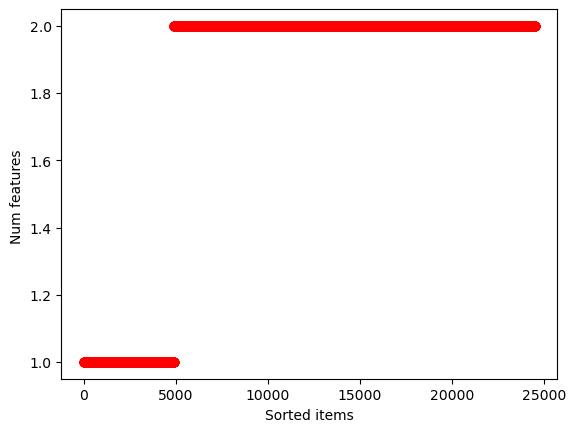

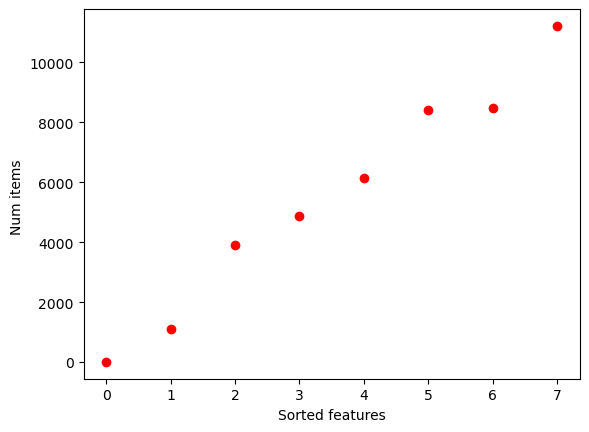

In [34]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

In [35]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.85)


In [36]:
best_hyperparams_ItemKNNCF = {'topK': 700, 'shrink': 200, 'similarity': 'cosine', 'normalize': True}
best_hyperparams_ItemKNNCBF = {'topK': 500, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True}

In [37]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_hyperparams_ItemKNNCF)

itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
itemKNNCBF.fit(**best_hyperparams_ItemKNNCBF)

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 532.98 column/sec. Elapsed time 45.98 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1522.38 column/sec. Elapsed time 16.10 sec


In [38]:
W_sparse_CF = itemKNNCF.W_sparse
W_sparse_CBF = itemKNNCBF.W_sparse

In [39]:
W_sparse_CF_sorted = np.sort(W_sparse_CF.data.copy())
W_sparse_CBF_sorted = np.sort(W_sparse_CBF.data.copy())

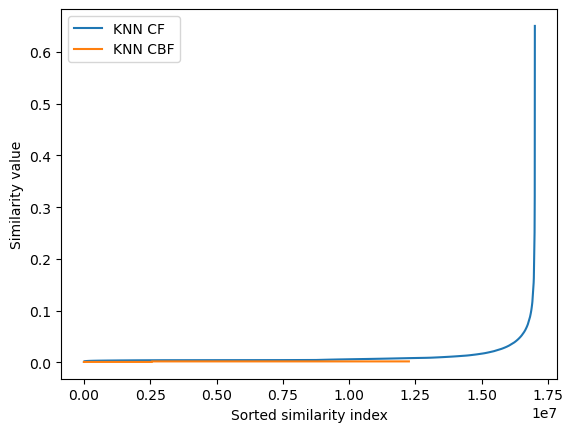

In [40]:
import numpy as np
import matplotlib.pyplot as pyplot


pyplot.plot(W_sparse_CF_sorted, label = 'KNN CF')
pyplot.plot(W_sparse_CBF_sorted, label = 'KNN CBF')
pyplot.ylabel('Similarity value')
pyplot.xlabel('Sorted similarity index')
pyplot.legend()
pyplot.show()

In [41]:
# Get common structure
W_sparse_CF_structure = W_sparse_CF.copy()
W_sparse_CF_structure.data = np.ones_like(W_sparse_CF_structure.data)

W_sparse_CBF_structure = W_sparse_CBF.copy()
W_sparse_CBF_structure.data = np.ones_like(W_sparse_CBF_structure.data)

W_sparse_common = W_sparse_CF_structure.multiply(W_sparse_CBF_structure)

# Get values of both in common structure of CF
W_sparse_delta = W_sparse_CBF.copy().multiply(W_sparse_common)
W_sparse_delta -= W_sparse_CF.copy().multiply(W_sparse_common)

In [42]:
W_sparse_delta_sorted = np.sort(W_sparse_delta.data.copy())

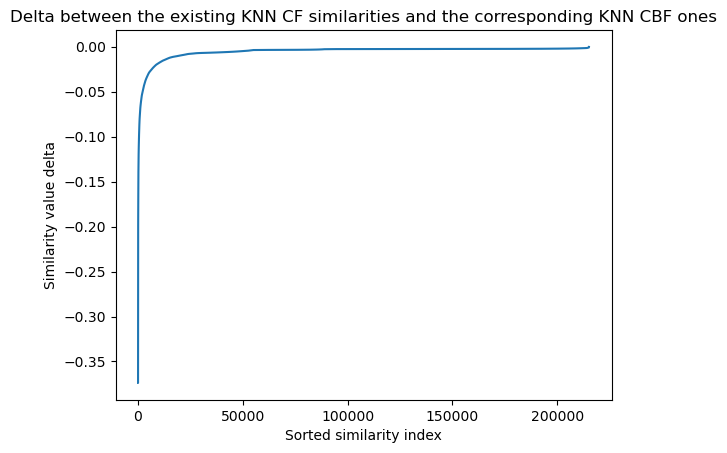

In [43]:
pyplot.plot(W_sparse_delta_sorted)
pyplot.ylabel('Similarity value delta')
pyplot.xlabel('Sorted similarity index')
pyplot.title("Delta between the existing KNN CF similarities and the corresponding KNN CBF ones")
pyplot.show()

In [44]:
# How many values we have in common?

print("W_sparse_CF has {:.2E} values and {:.2f} % in common with CBF".format(W_sparse_CF.nnz, W_sparse_common.nnz/W_sparse_CF.nnz*100))
print("W_sparse_CBF has {:.2E} values and {:.2f} % in common with CF".format(W_sparse_CBF.nnz, W_sparse_common.nnz/W_sparse_CBF.nnz*100))

print("W_sparse_delta has {:.2E} values".format(W_sparse_delta.nnz))

W_sparse_CF has 1.70E+07 values and 1.27 % in common with CBF
W_sparse_CBF has 1.23E+07 values and 1.76 % in common with CF
W_sparse_delta has 2.15E+05 values


In [39]:
W_sparse_delta = W_sparse_delta.tocoo()

In [27]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
SLIM = SLIMElasticNetRecommender(URM_train)
SLIM.fit()

SLIMElasticNetRecommender: URM Detected 32 ( 0.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 206 ( 0.7%) items with no interactions.
SLIMElasticNetRecommender: Processed 6287 (20.0%) in 5.00 min. Items per second: 20.95
SLIMElasticNetRecommender: Processed 12247 (38.9%) in 10.00 min. Items per second: 20.41
SLIMElasticNetRecommender: Processed 18148 (57.6%) in 15.00 min. Items per second: 20.16
SLIMElasticNetRecommender: Processed 24105 (76.5%) in 20.00 min. Items per second: 20.09
SLIMElasticNetRecommender: Processed 29510 (93.7%) in 25.00 min. Items per second: 19.67
SLIMElasticNetRecommender: Processed 31507 (100.0%) in 29.67 min. Items per second: 17.70


In [28]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


EvaluatorHoldout: Ignoring 4975 ( 6.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 3509 ( 4.5%) Users that have less than 1 test interactions


In [30]:
results_df, _ = evaluator_test.evaluateRecommender(SLIM)
results_df

EvaluatorHoldout: Processed 73992 (100.0%) in 27.52 sec. Users per second: 2689


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.000061,0.000123,0.000117,0.000013,0.00003,0.000131,0.000081,0.00008,0.000608,0.000131,...,0.954723,0.000581,0.954723,0.001068,5.430819,0.966055,0.0034,0.417972,0.01714,0.447452


In [30]:

from skopt.space import Real, Integer, Categorical

hyperparameters_range_dictionary = {
    "topK": Integer(5, 1000),
    "shrink": Integer(0, 1000),
    "similarity": Categorical(["cosine"]),
    "normalize": Categorical([True, False]),
}

from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt

recommender_class = ItemKNN_CFCBF_Hybrid_Recommender

hyperparameterSearch = SearchBayesianSkopt(recommender_class,
                                         evaluator_validation=evaluator_validation,
                                         evaluator_test=evaluator_test)

from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
  
recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train,ICM_all],     # For a CBF model simply put [URM_train, ICM_train]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train_validation,ICM_all],     # For a CBF model simply put [URM_train_validation, ICM_train]
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {},
    EARLYSTOPPING_KEYWORD_ARGS = {},
)

import os

output_folder_path = "result_experiments/"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    
n_cases = 10  # using 10 as an example
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP"   
cutoff_to_optimize = 10

hyperparameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       hyperparameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = n_random_starts,
                       save_model = "last",
                       output_folder_path = output_folder_path, # Where to save the results
                       output_file_name_root = recommender_class.RECOMMENDER_NAME, # How to call the files
                       metric_to_optimize = metric_to_optimize,
                       cutoff_to_optimize = cutoff_to_optimize,
                      )


Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'topK': 550, 'shrink': 642, 'similarity': 'cosine', 'normalize': False}
ItemKNN_CFCBF_HybridRecommender: URM Detected 40 ( 0.1%) users with no interactions.
ItemKNN_CFCBF_HybridRecommender: URM Detected 218 ( 0.7%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 31507 (100.0%), 642.09 column/sec. Elapsed time 49.07 sec
EvaluatorHoldout: Processed 72568 (100.0%) in 50.74 sec. Users per second: 1430
SearchBayesianSkopt: New best config found. Config 0: {'topK': 550, 'shrink': 642, 'similarity': 'cosine', 'normalize': False} - results: PRECISION: 0.0747671, PRECISION_RECALL_MIN_DEN: 0.1818373, RECALL: 0.1758570, MAP: 0.0392067, MAP_MIN_DEN: 0.0935632, MRR: 0.2212135, NDCG: 0.1491405, F1: 0.1049246, HIT_RATE: 0.4271855, ARHR_ALL_HITS: 0.2899515, NOVELTY: 0.0029892, AVERAGE_POPULARITY: 0.3932135, DIVERSITY_MEAN_INTER_LIST: 0.8112231,

Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 91.4346
Function value obtained: -0.0584
Current minimum: -0.0584
Iteration No: 5 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'topK': 299, 'shrink': 0, 'similarity': 'cosine', 'normalize': False}
ItemKNN_CFCBF_HybridRecommender: URM Detected 40 ( 0.1%) users with no interactions.
ItemKNN_CFCBF_HybridRecommender: URM Detected 218 ( 0.7%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 31507 (100.0%), 744.21 column/sec. Elapsed time 42.34 sec
EvaluatorHoldout: Processed 72568 (100.0%) in 45.08 sec. Users per second: 1610
SearchBayesianSkopt: Config 4 is suboptimal. Config: {'topK': 299, 'shrink': 0, 'similarity': 'cosine', 'normalize': False} - results: PRECISION: 0.0766729, PRECISION_RECALL_MIN_DEN: 0.1865419, RECALL: 0.1803646, MAP: 0.0403240, MAP_MIN_DEN: 0.0960392, MRR: 0.2261375, NDCG: 0.1528721, F1: 0.107

EvaluatorHoldout: Processed 73997 (100.0%) in 34.86 sec. Users per second: 2123
SearchBayesianSkopt: Config evaluated with evaluator_test. Config: {'topK': 1000, 'shrink': 0, 'similarity': 'cosine', 'normalize': True} - results:
CUTOFF: 10 - PRECISION: 0.1274011, PRECISION_RECALL_MIN_DEN: 0.2738695, RECALL: 0.2598811, MAP: 0.0745728, MAP_MIN_DEN: 0.1547015, MRR: 0.3306240, NDCG: 0.2336946, F1: 0.1709820, HIT_RATE: 0.5643067, ARHR_ALL_HITS: 0.4858894, NOVELTY: 0.0035107, AVERAGE_POPULARITY: 0.2201816, DIVERSITY_MEAN_INTER_LIST: 0.9571007, DIVERSITY_HERFINDAHL: 0.9957088, COVERAGE_ITEM: 0.5881868, COVERAGE_ITEM_HIT: 0.1184816, ITEMS_IN_GT: 0.9472181, COVERAGE_USER: 0.9547877, COVERAGE_USER_HIT: 0.5387930, USERS_IN_GT: 0.9547877, DIVERSITY_GINI: 0.0517858, SHANNON_ENTROPY: 9.8219317, RATIO_DIVERSITY_HERFINDAHL: 0.9962266, RATIO_DIVERSITY_GINI: 0.1649362, RATIO_SHANNON_ENTROPY: 0.7559928, RATIO_AVERAGE_POPULARITY: 1.7912967, RATIO_NOVELTY: 0.2985287, 


Iteration No: 9 ended. Search finish

In [31]:
from Recommenders.DataIO import DataIO

data_loader = DataIO(folder_path = output_folder_path)
search_metadata = data_loader.load_data(recommender_class.RECOMMENDER_NAME + "_metadata.zip")

search_metadata.keys()

dict_keys(['algorithm_name_recommender', 'algorithm_name_search', 'cutoff_to_optimize', 'exception_list', 'hyperparameters_best', 'hyperparameters_best_index', 'hyperparameters_df', 'metric_to_optimize', 'result_on_earlystopping_df', 'result_on_last', 'result_on_test_best', 'result_on_test_df', 'result_on_validation_best', 'result_on_validation_df', 'time_df', 'time_on_last_df', 'time_on_test_avg', 'time_on_test_total', 'time_on_train_avg', 'time_on_train_total', 'time_on_validation_avg', 'time_on_validation_total'])

In [32]:
hyperparameters_df = search_metadata["hyperparameters_df"]
hyperparameters_df

,topK,shrink,similarity,normalize
0,550,642,cosine,False
1,550,265,cosine,True
2,785,481,cosine,True
3,5,0,cosine,True
4,299,0,cosine,False
5,206,1000,cosine,True
6,991,5,cosine,True
7,43,998,cosine,False
8,1000,0,cosine,True
9,991,998,cosine,True


In [33]:
result_on_validation_df = search_metadata["result_on_validation_df"]
result_on_validation_df

,,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
,cutoff,,,,,,,,,,,,,,,,,,,,,
0,10,0.074767,0.181837,0.175857,0.039207,0.093563,0.221213,0.149141,0.104925,0.427186,0.289951,...,0.936349,0.399995,0.936349,0.005482,6.83164,0.981631,0.017461,0.52583,3.199005,0.254177
1,10,0.102694,0.248028,0.239486,0.056581,0.132423,0.287205,0.203753,0.143748,0.520519,0.396695,...,0.936349,0.487387,0.936349,0.013779,8.537535,0.993463,0.043887,0.657133,2.159883,0.276086
2,10,0.097557,0.236515,0.228437,0.053682,0.126347,0.277929,0.194953,0.136724,0.505278,0.380137,...,0.936349,0.473116,0.936349,0.010406,8.133005,0.991611,0.033143,0.625996,2.344743,0.270407
3,10,0.110268,0.261812,0.252475,0.058409,0.133969,0.286535,0.209523,0.153496,0.532218,0.402759,...,0.936349,0.498342,0.936349,0.077144,10.953853,0.998688,0.245701,0.843117,1.301494,0.318732
4,10,0.076673,0.186542,0.180365,0.040324,0.096039,0.226137,0.152872,0.107604,0.435412,0.297303,...,0.936349,0.407698,0.936349,0.007188,7.076322,0.983396,0.022893,0.544664,3.09148,0.256876
5,10,0.096657,0.233073,0.224872,0.053105,0.124233,0.275994,0.192423,0.135201,0.502177,0.376609,...,0.936349,0.470213,0.936349,0.011972,8.210095,0.991947,0.038131,0.63193,2.345548,0.271075
6,10,0.110498,0.265451,0.256296,0.061098,0.142328,0.299741,0.217177,0.15442,0.538777,0.421031,...,0.936349,0.504484,0.936349,0.043407,9.664672,0.996024,0.138249,0.743889,1.812482,0.295323
7,10,0.084235,0.204126,0.197256,0.045144,0.106254,0.244337,0.167454,0.118056,0.459597,0.326831,...,0.936349,0.430343,0.936349,0.016799,8.099762,0.990075,0.053503,0.623438,2.61177,0.269023
8,10,0.110421,0.265425,0.256294,0.06112,0.142391,0.299912,0.217201,0.154344,0.53773,0.421234,...,0.936349,0.503503,0.936349,0.051086,9.808254,0.99621,0.162706,0.75494,1.78705,0.298436


In [34]:
result_best_on_test = search_metadata["result_on_last"]
result_best_on_test

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.144323,0.30034,0.282642,0.101219,0.200067,0.394608,0.277327,0.191078,0.579861,0.611983,...,0.954788,0.553644,0.954788,0.037704,9.569826,0.995968,0.11965,0.736444,1.787248,0.250334


In [35]:
best_hyperparameters_ItemKNNCF = {'topK': 816, 'shrink': 0, 'similarity': 'cosine', 'normalize': True}
best_hyperparameters = search_metadata["hyperparameters_best"]
best_hyperparameters

{'topK': 1000, 'shrink': 0, 'similarity': 'cosine', 'normalize': True}

In [41]:
#best_hyperparams_ItemKNNCF = best_hyperparameters
best_hyp = {'topK': 1000, 'shrink': 0, 'similarity': 'cosine', 'normalize': True}
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender
itemKNNCF = ItemKNN_CFCBF_Hybrid_Recommender(URM_train,ICM_all)
itemKNNCF.fit(**best_hyp)

results_df, _ = evaluator_test.evaluateRecommender(itemKNNCF)
results_df

ItemKNN_CFCBF_HybridRecommender: URM Detected 42 ( 0.1%) users with no interactions.
ItemKNN_CFCBF_HybridRecommender: URM Detected 206 ( 0.7%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 31507 (100.0%), 448.26 column/sec. Elapsed time 1.17 min
EvaluatorHoldout: Processed 73957 (100.0%) in 37.35 sec. Users per second: 1980


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.127037,0.271564,0.257512,0.074261,0.153476,0.328495,0.23205,0.17014,0.560272,0.483409,...,0.954272,0.534651,0.954272,0.069322,10.117576,0.996589,0.220474,0.778586,1.745509,0.30546


In [318]:
best_hyperparams_ItemKNNCF = best_hyperparameters
best_shrink = 0
urm_train_validation = URM_train + URM_validation
best_recommender = ItemKNNCFRecommender(URM_all)
best_recommender.fit(**best_hyperparams_ItemKNNCF)


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 31507 (100.0%), 478.00 column/sec. Elapsed time 1.10 min


In [39]:
recommender_object = ItemKNN_CFCBF_Hybrid_Recommender(URM_all,ICM_all)
recommender_object

In [40]:
recommender_object.load_model(output_folder_path, 
                              file_name = recommender_object.RECOMMENDER_NAME + "_best_model_last.zip" )

ItemKNN_CFCBF_HybridRecommender: Loading model from file 'result_experiments/ItemKNN_CFCBF_HybridRecommender_best_model_last.zip'
ItemKNN_CFCBF_HybridRecommender: Loading complete


In [41]:
path4 = path + '/data_target_users_test.csv'
users_to_recommend = pd.read_csv(path4)
users_to_recommend

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
41111,41624
41112,41625
41113,41626
41114,41627


In [43]:

import scipy.sparse as sp
def prepare_submission(ratings: pd.DataFrame, users_to_recommend: np.array, urm_train: sp.csr_matrix, recommender: object):
    users_ids_and_mappings = user_original_ID_to_index.to_frame()
    users_ids_and_mappings = users_ids_and_mappings.drop_duplicates()
    users_ids_and_mappings = users_ids_and_mappings.reset_index(level=0)
    users_ids_and_mappings.columns = ["mapped_user_id","user_id"]
    users_ids_and_mappings = users_ids_and_mappings[users_ids_and_mappings.user_id.isin(users_to_recommend["user_id"])][["mapped_user_id", "user_id"]].drop_duplicates()
    
    items_ids_and_mappings = item_original_ID_to_index.to_frame()
    items_ids_and_mappings = items_ids_and_mappings.drop_duplicates()
    items_ids_and_mappings = items_ids_and_mappings.reset_index(level=0)
    items_ids_and_mappings.columns = ["mapped_item_id","item_id"]
    
    inv_map = dict(item_original_ID_to_index)
    mapping_to_item_id = {v: k for k, v in inv_map.items()}
    
    
    recommendation_length = 10
    submission = []
    for idx, row in users_ids_and_mappings.iterrows():
        user_id = row.user_id
        mapped_user_id = row.mapped_user_id
        
        recommendations = recommender.recommend(int(mapped_user_id),10)
        print(user_id ,",", *recommendations)
        rec_list = [mapping_to_item_id[ItemID] for ItemID in recommendations]
        submission.append((user_id, rec_list))
        
    return submission


In [44]:
submission = prepare_submission(URM_all, users_to_recommend, URM_train_validation, recommender_object)


0 , 88 343 307 1178 113 1966 445 99 1968 187
1 , 8601 556 2384 440 189 1292 5292 958 188 1875
2 , 1879 3723 1 2043 3721 3731 4262 2033 4252 1178
3 , 1 88 343 1287 358 307 2384 1291 6 556
4 , 343 1 187 6 1035 188 189 2 88 2384
5 , 1 186 2384 188 67 208 307 314 556 359
6 , 188 187 959 958 208 556 343 2384 1 189
7 , 1 2 187 343 358 88 1929 209 6 958
8 , 2231 2366 2204 2236 2265 2201 2242 768 2238 2306
9 , 1 343 187 358 307 958 2384 556 208 489
10 , 1367 2 1 7597 806 2956 7646 88 216 198
11 , 1 3937 187 307 5120 309 6 383 698 1632
12 , 1178 445 27 908 119 2050 110 93 2014 1132
13 , 16067 171 6469 2001 15127 19641 2038 16177 23027 16223
14 , 2 343 187 307 6 376 1035 358 314 208
15 , 2 343 6 475 307 187 1035 2975 489 3158
16 , 2 343 1555 88 6 376 307 187 1035 314
17 , 2 1 499 88 216 187 343 489 6 307
18 , 487 309 1611 2499 8356 2716 1620 4098 2525 2503
19 , 585 550 343 1948 187 190 88 2183 2777 189
20 , 475 2242 2265 2209 2236 2366 430 1 2246 2217
21 , 159 1378 3585 3696 135 1156 6014 101 26

376 , 1178 2050 1966 119 1176 113 1002 141 460 908
377 , 1 1137 103 358 2384 958 67 188 343 1221
378 , 1 88 343 376 187 6 307 209 489 958
379 , 1 208 188 186 1287 2 1292 958 189 2384
380 , 962 3923 4092 1000 10242 5808 15340 4096 963 3153
381 , 1590 1221 1215 100 1061 1867 837 3634 101 1137
382 , 1 2 343 6 358 88 187 475 958 1035
383 , 1590 1061 837 1218 1217 105 1137 4707 101 3638
384 , 762 811 1292 189 1297 807 187 2384 188 2171
385 , 1 2 187 103 343 208 1221 376 307 358
386 , 1 358 343 6 209 187 959 188 556 67
387 , 1 343 445 99 1178 908 314 544 2429 113
388 , 1 343 188 189 2384 2 67 556 358 988
389 , 837 1 1215 103 101 1590 100 88 1061 1137
390 , 5811 2716 9014 6249 1620 318 500 5821 501 4171
391 , 21751 20260 9023 1526 18290 17778 20113 18963 22048 19726
392 , 208 88 358 556 188 2384 6 67 307 958
393 , 1 2 343 188 187 358 376 556 208 6
394 , 5805 1620 318 2716 309 101 5839 487 500 6364
395 , 1215 1221 1061 100 1867 3634 1955 4231 105 2424
396 , 187 358 2 307 556 88 189 188 6 1221


690 , 101 1221 1215 105 1590 190 726 1218 103 100
691 , 1221 67 958 1590 1 343 189 208 209 959
692 , 343 314 1 307 187 489 3131 1035 2 186
693 , 1 1221 2 187 837 1215 343 101 1590 307
694 , 343 67 2384 959 988 5 1875 307 1291 3090
695 , 209 358 1 440 958 187 556 188 208 376
696 , 6644 17464 7712 9721 1984 5906 12416 14238 4865 659
697 , 962 3641 963 10868 3923 9623 5808 4337 10172 6341
698 , 2384 1292 2171 187 811 188 67 556 1297 1718
699 , 183 1879 184 2043 4262 155 544 3721 166 4252
700 , 475 1 2 88 187 358 1670 208 6 2956
701 , 1879 151 166 2043 3723 155 167 3721 184 3731
702 , 1 187 343 307 101 837 97 2 1137 188
703 , 649 8579 8587 147 2 3206 138 1329 1328 148
704 , 4122 148 3811 101 1215 103 1 1590 1137 182
705 , 5805 318 309 487 500 5806 501 5807 310 2716
706 , 138 1 187 88 343 1221 3585 103 307 1137
707 , 343 1 186 189 67 2384 208 307 188 1292
708 , 1 343 187 2384 307 188 67 88 2 186
709 , 343 187 2384 67 556 208 307 1292 6 358
710 , 314 307 2 88 6 187 186 1035 376 202
712 , 556

1058 , 962 3922 4687 5879 187 343 123 3780 218 89
1059 , 1590 837 1218 222 1061 100 4707 103 3949 5033
1060 , 343 1 209 958 314 187 959 307 208 6
1061 , 1590 1221 1061 103 100 1217 837 1867 1218 1137
1062 , 101 1221 837 1215 1137 1065 105 3085 100 1178
1063 , 8 1178 99 908 27 1960 560 1968 2050 843
1064 , 318 308 5821 309 487 2716 8355 6249 689 500
1065 , 1 343 187 88 6 103 188 1221 101 358
1066 , 97 10449 1 2 88 20994 5311 187 5581 8580
1067 , 10306 837 101 1221 100 1590 6911 1215 20655 1137
1068 , 500 2716 1814 698 2525 501 5811 5821 1823 8355
1069 , 803 654 187 1292 988 1875 807 189 2 88
1070 , 1 307 187 2 1221 188 6 1137 2384 88
1071 , 188 2384 67 958 343 208 1292 988 959 359
1072 , 1879 151 183 166 184 167 155 4262 2043 3731
1073 , 17 1178 580 2050 1968 27 1960 575 3274 119
1074 , 155 184 167 4262 166 3721 2043 170 3730 2033
1075 , 556 209 67 440 959 358 1288 3181 5373 208
1076 , 343 187 556 188 208 67 2384 2 958 189
1077 , 343 556 2384 208 189 314 186 358 2 958
1078 , 343 2 6 88 

1400 , 2716 501 500 318 487 309 308 5816 1777 5496
1401 , 1 343 2 88 958 654 376 307 186 188
1402 , 1178 908 113 27 560 1911 1956 99 544 843
1403 , 308 318 487 309 1611 500 13847 1631 501 97
1404 , 908 445 845 3265 21305 553 3257 551 119 3673
1405 , 3214 25 4654 3269 6356 97 963 691 7189 998
1406 , 500 1620 318 308 5819 699 5805 310 2520 2499
1407 , 726 1 103 585 1215 87 1137 343 1948 100
1408 , 187 2384 208 958 1 988 209 67 556 1288
1409 , 6000 5249 5257 5087 5993 8755 3714 4635 5283 6017
1410 , 1 88 343 187 6 307 188 358 958 2384
1411 , 2943 698 3644 383 2526 500 4164 3648 487 722
1412 , 378 1670 419 89 554 1 97 995 842 999
1413 , 1590 1215 3638 3634 4707 1063 2424 3637 1137 4706
1414 , 1 187 2 220 208 343 88 189 358 1287
1415 , 1 2 343 187 489 88 188 358 307 556
1416 , 3426 20025 12690 1724 1748 1462 3470 20641 9494 18489
1417 , 5182 6606 21062 3040 14519 15013 14974 9345 19485 9502
1418 , 3644 3649 3648 384 1469 8356 500 3524 3645 4164
1419 , 376 1 343 2 88 307 6 187 1035 186
1420 

1731 , 901 3045 1692 320 1694 1 1908 2095 343 2
1732 , 445 1956 3265 113 2050 572 3091 1178 110 1911
1733 , 138 4122 4106 3929 16684 3811 209 182 67 959
1734 , 358 1 188 67 958 189 1292 343 2384 556
1735 , 148 103 1 1215 101 2384 837 67 358 343
1736 , 1221 1215 1218 1061 100 3634 4707 4706 1217 3638
1737 , 16172 16173 847 2 88 962 376 475 307 343
1738 , 487 5807 308 1611 5805 500 501 2716 310 1620
1739 , 3210 8020 25 4654 1779 962 3519 3520 3919 219
1740 , 88 187 343 6 358 307 188 376 208 209
1741 , 1 2384 67 988 958 358 186 2 440 189
1742 , 184 166 2043 167 2033 158 2905 170 2023 5645
1743 , 120 97 995 378 3270 444 89 1 419 1929
1744 , 101 1221 1137 1378 105 837 135 960 100 159
1745 , 1590 1221 1218 837 1867 1217 103 4707 3638 1955
1746 , 187 2384 208 988 189 958 1292 343 2171 440
1747 , 2247 2198 2296 2301 2222 18762 2370 2380 2336 2265
1748 , 101 3585 159 1156 1221 103 1137 113 102 3696
1749 , 1590 1221 1061 103 837 1867 100 3634 1063 1218
1750 , 2555 5755 5749 171 17785 5663 18476 

2084 , 343 2 1215 1221 103 187 837 100 1061 1218
2085 , 1221 1 103 2 187 1215 208 101 1218 3638
2086 , 188 209 343 208 187 67 2384 958 959 988
2087 , 187 189 67 186 358 1292 307 2 6 1291
2089 , 10101 320 1694 10102 189 901 6 3997 103 343
2090 , 97 309 1879 183 184 1 3723 2043 3721 155
2091 , 343 187 307 6 208 1035 489 188 358 189
2092 , 534 13411 531 12269 23725 15352 2255 2265 8801 2375
2093 , 1 3158 376 414 120 123 995 88 95 444
2094 , 97 89 444 1 187 123 1929 103 186 2
2095 , 309 4654 8020 6342 1779 14406 500 3214 3210 3213
2096 , 1 187 67 556 189 2384 1292 208 186 2171
2097 , 186 1 187 189 1292 208 2171 188 2384 556
2098 , 5868 3922 5865 962 97 5867 5927 910 5879 282
2099 , 1 88 343 1035 1537 2 187 1172 307 2384
2100 , 1 556 958 343 188 2384 307 67 186 189
2101 , 170 183 1197 1590 1879 1215 100 1061 1221 1867
2102 , 1137 100 1215 1590 1218 105 2 1061 187 343
2103 , 1879 183 151 184 155 166 3721 2043 3730 3731
2104 , 9461 9458 9459 6438 8562 8563 8550 8561 9460 1
2105 , 1221 837 1 1

2426 , 97 101 1 3654 103 1057 1063 960 182 1215
2427 , 187 188 556 343 2384 189 208 1292 209 359
2428 , 1 435 343 6 358 307 1035 958 556 959
2429 , 958 188 103 556 440 2384 67 1 1221 208
2430 , 1590 1221 1061 100 837 3949 1955 4707 1218 1217
2431 , 343 103 2 88 89 307 1221 1929 376 1215
2432 , 17875 16119 23913 23869 2031 13541 17704 11883 23591 22485
2433 , 1221 1215 103 100 3818 837 1061 1137 1218 4707
2434 , 183 151 1879 166 3723 170 103 101 2043 105
2435 , 1 2 187 343 88 307 314 358 6 489
2436 , 97 3514 998 3923 3647 4364 378 3922 383 963
2437 , 5526 2296 768 2246 2245 18440 2255 6330 9598 9091
2438 , 1 2 343 1035 187 358 489 307 376 314
2439 , 1 188 189 556 2384 307 208 67 1292 358
2440 , 97 1 419 5865 1670 3922 1221 100 842 554
2441 , 67 343 440 189 958 1292 359 186 209 959
2442 , 97 378 1 187 89 343 1929 95 556 208
2443 , 378 89 123 142 120 1929 2 995 88 95
2444 , 209 959 440 1 567 958 2384 556 67 435
2445 , 343 2 208 6 186 376 358 188 1035 314
2446 , 1 376 309 6 343 307 318 500

2747 , 187 189 186 2384 67 188 307 556 1292 208
2748 , 2 343 88 307 489 187 475 1035 314 654
2749 , 496 6888 1 706 376 1017 343 1327 500 2
2750 , 103 1137 105 1590 1671 1218 1217 548 1061 1063
2751 , 188 556 208 343 186 440 209 5 1288 1868
2752 , 384 3647 3919 2602 3211 962 3922 3210 3214 3213
2753 , 4164 500 501 5496 378 4673 487 4130 1929 14602
2754 , 188 1 1694 343 208 556 189 187 320 2384
2755 , 3211 3214 3213 97 6342 378 14406 384 25 8020
2756 , 2424 3949 2048 4231 9787 2474 1957 5261 105 1221
2757 , 187 1291 1296 1292 2967 1287 2176 208 762 988
2758 , 209 959 440 187 67 2384 188 1 5 435
2759 , 5868 8179 4122 9551 4106 282 1774 5927 910 3779
2760 , 6 2 186 2384 88 67 188 189 489 208
2761 , 1 343 1378 2 88 187 103 6 101 376
2762 , 5805 318 500 501 310 5806 2713 5807 1465 699
2763 , 3211 3210 962 3209 6342 2602 97 25 8020 384
2764 , 501 308 1620 2716 699 5807 5806 2499 1777 310
2765 , 343 1 186 67 2384 88 314 188 189 208
2766 , 500 501 2499 5806 1 1463 2716 5807 1462 97
2767 , 308 4

3095 , 2 343 6 187 376 307 358 489 1035 202
3096 , 1 187 544 188 88 190 189 6 208 1178
3097 , 1879 167 183 166 184 1205 2043 3730 155 4262
3098 , 187 2 202 6 314 1035 489 188 2384 358
3099 , 1 1221 837 101 100 1218 1215 187 105 1590
3100 , 1590 1215 103 1061 1867 3634 1137 101 187 2384
3101 , 343 489 187 6 1035 376 208 307 358 314
3102 , 2602 1 1017 1327 962 3357 378 3514 1929 187
3103 , 2095 4535 3045 2416 1908 1175 343 1172 313 1
3104 , 2 198 471 489 88 2738 187 1 214 499
3105 , 2 343 187 6 376 489 358 1035 208 186
3106 , 1221 103 837 105 1 1215 548 1065 960 100
3107 , 2 187 307 188 101 6 103 186 1178 2384
3108 , 343 1 13558 88 307 187 6 189 186 3131
3109 , 3723 4262 183 167 170 2905 2023 1197 1205 3305
3110 , 1 88 376 6 362 343 187 208 1555 10263
3111 , 343 18146 1 19472 2 9541 187 5535 6386 643
3112 , 4122 4106 1 1613 182 187 3811 88 97 2
3113 , 100 1215 103 101 837 1218 1217 105 1061 1867
3114 , 5886 3211 722 97 3158 378 3209 4098 123 3155
3115 , 309 500 5806 1620 5805 2499 1611 5

3481 , 202 343 2 1 2500 1616 1615 1035 504 307
3482 , 67 187 359 208 988 958 1 358 959 1288
3483 , 343 187 2 376 6 186 307 208 314 189
3484 , 22332 20238 10622 5417 5606 23632 19062 10073 4755 11438
3485 , 1590 1215 27 8178 1178 1061 4706 4231 5136 3634
3486 , 343 1 314 187 6 88 1172 1035 186 2384
3487 , 188 202 187 343 208 2384 186 2 1291 1288
3488 , 2975 378 103 97 1063 1215 1221 1590 539 649
3489 , 189 67 188 2384 1292 2171 208 359 343 1
3490 , 17660 209 959 187 208 1 958 1287 15905 2
3491 , 188 556 103 1221 343 1 189 138 837 4122
3492 , 2372 2379 2330 2374 2295 2340 768 879 19770 1449
3493 , 148 343 4106 2 88 187 307 1221 6 103
3494 , 2716 1330 3516 487 309 1620 308 1777 500 1109
3495 , 3214 25 151 1879 1779 889 1 544 554 170
3496 , 97 378 142 377 419 123 95 112 121 539
3497 , 1 475 2 97 378 88 187 343 1259 202
3498 , 1215 1221 101 100 1590 187 307 2 188 6
3499 , 1063 1221 837 100 1218 3949 103 2048 3638 4707
3500 , 487 500 501 97 3211 722 3209 1 318 3213
3501 , 376 1 88 6 307 343 

3849 , 2 376 343 187 6 358 307 1035 209 188
3850 , 2 1 376 343 307 6 202 1035 475 187
3851 , 343 1 1221 88 103 1215 188 2 187 6
3852 , 1 2 88 187 343 307 97 6 188 489
3853 , 2739 3519 3528 3509 8432 1050 19248 3510 22738 22946
3854 , 309 2499 318 500 5806 501 8356 5807 1620 310
3855 , 187 307 88 314 2 358 188 186 1035 208
3856 , 1 208 187 186 2 188 189 2384 2171 556
3857 , 1590 1221 1215 188 1218 837 189 208 100 6
3858 , 1 343 556 67 958 314 209 1035 1292 359
3859 , 3780 1537 6346 5114 3779 8022 3781 11249 5879 1338
3860 , 3969 3968 4690 8569 3967 8560 3216 1014 2744 3549
3861 , 2499 5811 2 343 307 9014 9648 5496 88 6
3862 , 1 343 187 188 6 2384 208 958 556 489
3863 , 414 1 97 187 2 400 343 88 378 103
3864 , 1 343 187 901 320 1694 6 103 188 2
3865 , 309 487 5805 1620 310 500 1611 1221 501 2716
3866 , 202 376 378 2 1 475 1616 88 1615 307
3867 , 487 16173 501 8356 2602 698 1620 962 343 88
3868 , 1215 837 1061 103 1867 1217 3638 3634 4707 1137
3869 , 103 100 1061 187 101 188 1867 3634 208

4199 , 4381 1692 901 103 1215 2095 1257 526 105 1694
4200 , 209 188 15167 1 959 958 343 103 6386 20302
4201 , 101 1 343 1137 187 2 960 1221 100 1215
4202 , 1879 166 3723 183 155 3721 3731 2043 2033 4262
4203 , 187 186 67 88 556 307 208 314 6 358
4204 , 2716 500 501 318 309 6004 1620 4130 308 343
4205 , 901 320 2416 1692 1175 487 318 1 4535 2095
4206 , 188 556 187 208 440 1 2384 958 358 343
4207 , 1 88 1221 6 101 1137 343 489 837 100
4208 , 1 188 187 189 67 2 958 208 314 186
4209 , 1 343 186 307 314 189 188 2 208 2384
4210 , 1221 1215 103 1218 837 1 4707 1061 1217 101
4211 , 1137 100 1215 1590 105 1 1061 1217 3638 1867
4212 , 1 2 376 88 378 343 307 187 654 489
4213 , 188 958 67 2384 959 1035 489 189 314 186
4214 , 2 475 88 343 187 6 103 307 358 208
4215 , 1218 4707 1061 3638 100 103 3634 1867 1955 4231
4216 , 343 188 11964 307 2384 67 208 6 186 376
4217 , 1 188 556 343 187 67 358 2 958 189
4218 , 6 88 187 489 1035 186 189 188 2384 208
4219 , 103 1215 1590 101 97 100 487 837 2 500
4220 ,

4562 , 16024 17831 9502 14032 24197 20238 17530 8441 8872 4254
4563 , 1929 18395 5260 2248 12281 15629 2297 329 9468 14999
4564 , 19281 2186 11438 22485 1566 23312 11140 5663 20476 18224
4565 , 343 1 187 307 188 6 440 1694 2384 556
4566 , 5869 1774 5865 3779 3173 3781 3780 3922 223 3652
4567 , 1178 119 27 17 2014 447 2050 1959 1966 544
4568 , 487 309 2525 1611 1620 308 1777 2503 5805 2499
4569 , 188 67 2384 189 440 2171 988 359 208 187
4570 , 175 1137 1 103 105 1221 1065 343 2 960
4571 , 189 1 343 188 2171 811 2384 67 1292 208
4572 , 5869 5865 3173 5879 3647 1 5927 378 910 5124
4573 , 88 343 6 376 187 489 1035 208 314 671
4574 , 307 6 187 1035 489 376 314 186 208 188
4575 , 9438 343 314 1 6 88 202 1035 307 67
4576 , 208 1 188 1287 67 2 358 189 958 186
4577 , 378 1537 1 88 187 343 2 186 995 307
4578 , 19019 560 3585 6014 175 93 1156 159 2050 3206
4579 , 343 2 187 6 307 88 314 671 489 188
4580 , 9502 2407 23061 1 13526 17872 16160 5749 19485 14698
4581 , 1590 1215 1221 105 100 3638 837 4

4869 , 187 2 1 208 88 1287 343 376 358 186
4870 , 378 1 121 384 123 187 2 88 142 1929
4871 , 1 2 88 208 376 6 307 378 188 186
4872 , 187 2384 358 959 1292 359 307 314 1287 1035
4873 , 343 187 307 6 358 489 1035 475 209 208
4874 , 5124 5114 3780 6355 6354 6364 11249 3922 6346 3781
4875 , 88 6 187 307 314 489 188 358 208 2384
4876 , 16173 704 1621 9471 701 847 9551 8179 22848 11065
4877 , 16903 11964 19019 20905 399 5966 1968 13745 6400 3325
4878 , 1 343 188 307 358 189 2384 376 6 958
4879 , 556 67 2384 343 209 1 440 208 1292 1288
4880 , 1 103 175 101 1378 2 1221 88 307 1215
4881 , 2055 2052 2005 1178 460 2030 2050 27 6811 5087
4882 , 2713 5496 1 4128 4673 6 307 332 187 343
4883 , 1215 1221 1218 4707 837 4706 3638 4231 3637 3949
4884 , 2384 501 307 358 67 1620 487 88 5811 314
4885 , 2 343 307 187 376 489 1035 314 188 202
4886 , 1 343 2 307 208 186 1035 2384 188 67
4887 , 189 1292 2171 807 208 762 67 1718 2384 556
4888 , 2 187 101 103 1221 88 3585 1156 343 1215
4889 , 2221 2231 97 19770 1

5212 , 188 440 1868 67 556 209 959 358 187 2384
5213 , 707 5496 487 500 309 2713 501 1327 97 4673
5214 , 1 2 343 1555 307 376 187 103 489 202
5215 , 1215 6014 103 837 3085 3585 100 3949 175 1063
5216 , 188 187 1 343 2384 440 189 209 1292 359
5217 , 67 2384 188 343 440 208 958 187 359 189
5218 , 343 2 103 307 1221 88 186 188 358 6
5219 , 1 2 187 343 307 6 378 475 2384 1287
5220 , 343 187 307 6 2 314 88 103 1035 188
5221 , 376 2 1 343 187 6 489 307 958 1035
5222 , 1 343 187 188 1670 307 376 208 2384 6
5223 , 1 2 487 419 97 187 91 378 88 500
5224 , 1178 445 3669 1968 119 101 27 17 544 2014
5225 , 376 88 6 187 343 489 307 1035 208 214
5226 , 698 501 384 97 3937 487 706 692 8356 2526
5227 , 11413 421 2298 16774 17852 14453 23312 5764 4383 2286
5228 , 962 493 376 10171 1 97 1000 378 963 19271
5229 , 1 97 378 120 376 3209 3210 89 187 489
5230 , 123 378 89 142 121 995 539 1929 2414 4098
5231 , 4337 9955 17869 12296 11075 7925 8552 19492 3153 17620
5232 , 500 501 5807 2499 1620 699 318 308 310 

5550 , 1221 1061 4707 3634 100 1218 1867 837 103 4706
5551 , 343 2 307 88 189 188 2384 208 556 67
5552 , 1879 183 3723 167 3721 184 151 4262 3731 166
5553 , 6 307 376 187 1035 314 202 654 208 358
5554 , 958 959 1 556 1590 1215 187 2384 1221 188
5555 , 101 1 103 837 343 1221 2 187 100 105
5556 , 1221 1137 837 1 343 105 187 100 1215 960
5557 , 1867 1292 988 359 3638 1217 3637 2 101 1291
5558 , 376 22042 19962 5419 11150 18201 22669 16434 13526 24127
5559 , 5120 534 3937 17066 13411 18233 7921 3520 3528 3509
5560 , 189 187 1 988 958 307 440 1875 358 1035
5561 , 1929 486 1 377 998 7425 3158 384 95 383
5562 , 1948 726 87 1197 190 1215 151 1879 170 183
5563 , 2 1 1035 343 489 488 376 202 6 307
5564 , 1221 1215 187 103 2 343 100 837 88 1137
5565 , 1 556 187 67 307 1221 186 837 958 359
5566 , 1590 837 1061 103 1218 1137 3634 3638 105 1955
5567 , 187 188 2 556 67 958 103 307 186 440
5568 , 2384 556 187 189 314 307 208 958 186 6
5569 , 17066 22218 7921 6698 2227 5006 3438 13746 21473 23724
5570 

5918 , 187 2 1035 2384 307 188 67 556 358 1292
5919 , 633 97 378 698 138 3919 962 1 3206 4122
5920 , 487 5805 308 310 500 1620 1463 2499 501 2716
5921 , 1215 1590 1221 1061 1218 1137 105 4231 3949 3638
5922 , 1221 1 1590 103 1061 101 2 1217 1218 187
5923 , 1 4106 88 376 6 186 188 489 314 358
5924 , 4122 3206 159 8587 182 7377 400 135 3696 1156
5925 , 3214 3209 6342 3211 8020 25 88 1779 4654 343
5926 , 188 189 2384 1 186 383 67 1292 556 1287
5927 , 3723 4262 3730 158 2905 1205 3305 7248 179 2058
5928 , 187 343 556 209 440 67 959 2 188 2384
5929 , 101 1221 1 1137 175 1215 343 2 307 187
5930 , 25 4654 1779 1 2 2966 12653 3968 343 88
5931 , 20100 1034 2602 4262 8706 21528 11297 23312 19818 11142
5932 , 2716 5805 23902 309 12053 308 6004 487 1 2525
5933 , 103 1061 3637 1137 1217 101 3949 1955 4231 5213
5934 , 9838 11948 11826 19494 2001 20342 21089 16843 3327 22101
5935 , 101 103 1215 837 100 105 1590 1 1061 1218
5936 , 309 487 318 5807 1611 500 501 1777 2716 13847
5937 , 1215 1 837 1590 11

6247 , 1215 1590 100 343 3638 101 187 1061 3085 1137
6248 , 187 88 358 188 376 6 186 2384 67 202
6249 , 1590 1215 837 1867 3634 3637 3638 1217 1137 1955
6250 , 1948 8570 726 585 87 200 6279 560 110 550
6251 , 2384 556 67 2 358 1292 314 359 440 1288
6252 , 837 1061 3638 101 1217 2424 4707 3634 1955 1063
6253 , 209 959 1590 958 1215 187 1 103 4707 1221
6254 , 2 88 343 6 307 2956 187 489 358 1035
6255 , 343 208 188 358 88 209 959 189 440 1288
6256 , 1590 1215 3634 2423 103 1061 123 1218 837 97
6257 , 1 343 187 208 489 67 307 358 958 189
6258 , 1 187 343 2 188 101 88 186 314 1137
6259 , 189 187 343 2171 2384 556 188 208 67 958
6260 , 376 2 1 419 187 343 202 307 378 6
6261 , 1590 4706 1218 4707 1215 5213 1061 3637 1221 103
6262 , 2096 88 1 13705 6569 6 376 489 475 14142
6263 , 1 475 2 343 88 307 6 3131 314 489
6264 , 183 170 3721 184 166 3723 167 155 2043 2033
6265 , 188 556 958 67 208 2384 440 959 343 1292
6266 , 1292 1 358 1288 1294 2 103 6 489 3087
6267 , 97 378 120 7425 2 1 142 419 995 

6613 , 500 3939 3937 698 697 97 722 962 384 318
6614 , 500 2716 501 2499 4130 5811 318 487 1620 309
6615 , 1620 309 308 2499 5821 1777 5805 1631 3355 4130
6616 , 2171 187 2384 208 556 188 67 359 1875 811
6617 , 343 358 2384 556 187 209 67 440 958 208
6618 , 103 2 343 187 88 376 358 489 314 1035
6619 , 1871 2605 6287 1692 901 1172 1257 1 320 376
6620 , 1929 378 91 995 1 89 112 561 780 2
6621 , 187 67 2384 189 1292 958 359 440 186 959
6622 , 188 67 5 186 389 343 2504 2174 1 868
6623 , 500 2499 2541 501 309 487 3358 4164 1017 3371
6624 , 1694 1 343 901 187 188 307 189 208 3045
6625 , 103 1215 1590 105 1218 1061 3638 1217 3949 548
6626 , 472 1367 2 1 2843 3257 213 23315 6 19651
6627 , 1221 1215 1590 556 101 837 67 187 1061 1218
6628 , 4122 2 88 1 97 5868 489 343 3811 307
6629 , 1879 183 151 3721 184 155 4262 167 2043 3731
6630 , 1 88 343 187 376 1035 97 6 358 489
6631 , 1221 837 1215 105 1590 100 1218 1061 3637 2424
6632 , 1590 1221 1061 1218 4231 2424 7380 3085 5136 222
6633 , 1215 1221 1

6982 , 1747 3426 2841 1224 2835 6833 2838 3427 3428 2839
6983 , 343 2 88 97 186 378 376 202 6 188
6984 , 1590 1215 1217 1 1137 3634 105 780 4707 3638
6985 , 1259 8380 21188 4578 1 11737 808 23632 419 17610
6986 , 15148 830 20796 12474 11279 14392 24402 23859 4023 6604
6987 , 3214 3213 3211 186 187 1 343 6342 97 14406
6988 , 4654 8020 1779 6342 3210 14406 3214 3213 88 3211
6989 , 1879 151 183 167 3721 2043 4262 3730 166 2033
6990 , 9119 2 4892 10449 5062 1 1205 11835 170 1747
6991 , 1 2 187 343 307 88 6 376 103 97
6992 , 1217 1215 1221 3585 100 3108 1590 101 1156 1137
6993 , 1 343 189 187 307 2 314 489 188 358
6994 , 487 2 187 500 343 88 378 4098 307 690
6995 , 11142 12749 5720 18499 73 14193 5733 5686 5667 6997
6996 , 1 958 343 2 188 209 208 67 307 186
6997 , 501 487 309 3530 9925 2716 308 5805 2503 1611
6998 , 1 343 6 307 188 189 208 314 320 186
6999 , 1867 100 4706 188 1137 2384 187 343 105 958
7000 , 1 343 2384 88 188 556 2 376 189 208
7001 , 67 2384 188 440 556 358 2171 187 186 129

7348 , 1590 1221 1061 837 1867 103 100 3634 4707 3638
7349 , 187 489 6 958 2384 188 314 556 189 959
7350 , 7202 893 6438 551 1496 1 2 2118 2676 552
7351 , 376 2 343 88 475 6 1259 307 187 1035
7352 , 501 309 1620 318 2716 2713 308 699 5816 7061
7353 , 4098 3210 3213 3209 3211 6342 1 14406 8020 186
7354 , 1221 1215 100 1590 1 1137 101 1218 1061 188
7355 , 16289 10623 4728 9449 5766 18084 13397 22024 2260 5325
7356 , 1590 1215 103 1221 100 837 1218 3634 1867 4707
7357 , 343 208 314 358 202 2384 188 189 67 958
7358 , 343 1 2416 307 6 18497 3045 5720 2190 314
7359 , 1632 13411 506 1628 697 378 531 16775 1625 187
7360 , 138 4106 3811 182 1 2 159 3206 2970 343
7361 , 1 2 88 2956 4299 187 307 343 6 358
7362 , 2 307 187 188 358 489 2384 186 208 958
7363 , 2064 1215 105 3085 101 1221 5280 9787 4231 2048
7364 , 320 1694 113 100 901 445 1221 103 1215 1968
7365 , 187 1 208 189 343 188 2 2384 67 358
7366 , 343 1 188 67 2384 307 556 189 208 1035
7367 , 343 358 209 187 958 959 556 6 88 188
7368 , 1 34

7712 , 1221 100 1590 1218 3949 6014 3585 3085 1063 3638
7713 , 101 100 1590 960 1218 1061 548 1217 1065 1867
7714 , 1221 1061 837 103 1218 1867 1217 3634 1137 486
7715 , 22732 2246 2242 2221 5271 2231 445 2220 2204 110
7716 , 3723 4252 2033 1205 3305 3317 4738 1207 560 544
7717 , 103 1137 1221 1215 100 105 101 1218 1590 960
7718 , 97 1 625 1063 101 103 1929 1138 89 837
7719 , 108 2 995 89 91 88 376 112 187 343
7720 , 188 2384 208 358 2 209 440 1292 359 1035
7721 , 20857 3384 19001 13041 20559 10937 18559 20937 14776 11524
7722 , 103 100 67 958 101 358 988 1137 186 1292
7723 , 1221 1061 100 837 1218 3634 1867 4707 4231 3638
7724 , 1178 27 1960 8 2050 1968 1911 843 93 3669
7725 , 1 343 187 2 358 188 88 2384 489 208
7726 , 1215 1221 1590 100 105 1218 1137 101 1063 3638
7727 , 1221 100 3638 3637 1955 1063 1217 4706 2424 4231
7728 , 1 187 67 188 2 208 2384 186 358 343
7729 , 2 88 343 187 307 376 103 6 654 208
7730 , 1221 1590 1215 101 1061 100 1867 837 103 1218
7731 , 1 487 309 501 187 88 3

8091 , 3732 19332 24486 21877 18134 17673 7616 6404 4033 5280
8092 , 1 343 97 2384 186 188 556 2 208 88
8093 , 1221 103 1 187 343 1137 188 1215 2384 837
8094 , 16903 19019 17463 489 1 343 16876 6400 2 4062
8095 , 3721 3723 2043 3730 4262 1879 166 378 3731 167
8096 , 962 97 2 378 187 11249 998 88 101 343
8097 , 343 307 6 314 2 187 88 1035 376 556
8098 , 16590 22813 20641 2407 12303 20096 20233 20559 11150 23187
8099 , 1 376 343 187 208 6 307 489 1287 209
8100 , 151 183 166 167 3721 4262 184 2043 3723 155
8101 , 187 6 376 314 208 489 358 1035 186 188
8102 , 487 500 1611 5806 2716 1465 501 1109 2503 8356
8103 , 2 88 343 5868 307 5866 2602 962 5867 202
8104 , 1 202 1537 1615 2 376 343 1616 88 307
8105 , 1 187 358 307 2 101 188 958 2384 103
8106 , 475 9805 103 1 2 1590 3714 5266 3949 837
8107 , 13243 24421 23869 20745 12926 8958 5756 525 20064 9448
8108 , 14759 15167 9552 22058 18150 378 14446 23608 706 707
8109 , 188 2384 187 556 1292 343 208 67 2171 186
8110 , 189 187 8352 188 343 2384 1 

8469 , 2 187 88 307 6 186 209 376 208 958
8470 , 1 187 343 188 2 958 2384 208 307 189
8471 , 1 343 88 187 487 307 6 97 378 186
8472 , 1221 4690 731 9130 2961 100 1590 2955 837 1215
8473 , 1590 1218 105 1217 3634 4707 101 3637 1 4706
8474 , 1956 560 2429 113 110 27 3301 222 5136 2777
8475 , 343 88 6 376 307 187 103 358 1590 1035
8476 , 7239 4231 5248 4707 3634 2424 1218 1590 3637 7862
8477 , 3939 500 501 697 3524 13411 487 698 309 3210
8478 , 487 309 1 101 2716 308 1620 187 5805 4285
8479 , 189 556 188 67 187 988 811 1875 762 343
8480 , 698 2856 3922 1327 1017 1612 487 501 998 5869
8481 , 1 2 376 187 88 188 358 307 208 2384
8482 , 1061 1217 4706 1955 105 1137 1063 1 4232 1759
8483 , 3811 182 159 3206 3585 3696 1378 7637 1152 147
8484 , 88 307 6 188 314 189 2384 208 358 67
8485 , 7084 3269 3294 11642 958 7090 959 358 556 2171
8486 , 1257 320 1172 1175 343 2095 2605 901 3045 187
8487 , 1 188 187 343 556 1257 1221 103 988 208
8488 , 343 307 2 489 314 188 88 1035 186 189
8489 , 1 187 343 20

8837 , 10172 8958 20400 14934 9038 15851 23487 21585 22006 16867
8838 , 318 309 500 501 1611 1 5806 310 5807 2716
8839 , 2499 11685 5496 9816 4673 310 5259 12534 10382 7380
8840 , 1221 1 187 837 101 188 343 1137 358 67
8841 , 120 89 95 121 487 309 318 1929 501 123
8842 , 88 343 376 6 187 307 489 1035 358 186
8843 , 1879 307 183 188 3721 4262 6 4252 67 189
8844 , 1378 445 4983 1911 1178 110 1956 1002 4987 119
8845 , 97 1929 3211 2 187 88 3214 307 376 186
8846 , 378 97 2 343 88 187 376 307 103 6
8847 , 2384 343 556 67 186 208 1292 988 307 359
8848 , 2 314 88 6 187 376 1035 489 2384 202
8850 , 1 343 378 187 2 314 307 88 89 120
8852 , 343 307 88 314 358 188 208 2384 67 958
8853 , 343 1 1257 6 2384 188 189 1694 208 3045
8854 , 1 2 187 343 189 489 88 208 314 556
8855 , 343 489 88 376 1035 307 216 358 187 435
8856 , 87 190 1948 550 725 1132 99 726 3084 110
8857 , 1221 103 1215 1137 100 1590 105 3949 1218 1061
8858 , 2384 988 958 189 440 1292 359 2171 1288 1868
8859 , 15509 3589 21911 3012 357

9198 , 1 101 2 187 88 1137 307 1221 97 1138
9199 , 3210 3214 1 500 962 501 2602 2 4654 4098
9200 , 762 1297 1718 3090 1875 13234 189 7712 17359 1292
9201 , 343 88 489 376 187 1035 314 358 208 202
9202 , 17 3669 27 1968 1002 119 460 908 113 553
9203 , 1879 151 3723 184 155 4262 3721 2033 3730 158
9204 , 585 4304 1948 97 378 2667 24087 2043 183 1879
9205 , 3485 7781 5528 5537 7619 1 6 2416 1257 7789
9206 , 343 187 487 2 309 308 2716 378 1620 88
9207 , 190 585 87 99 1197 3573 200 2777 1132 1207
9208 , 376 2 208 9975 1 358 187 959 209 1287
9209 , 3634 1590 1867 1218 4707 1221 3637 1215 1061 837
9210 , 501 318 308 1620 310 2503 5805 5807 2499 2716
9211 , 3520 5925 17066 8352 3528 12888 962 14229 8553 383
9212 , 343 2 187 88 314 307 489 1035 358 208
9213 , 1 2 343 187 358 188 959 6 489 2384
9214 , 343 2 6 88 187 307 314 376 1035 186
9215 , 704 1929 847 701 1 187 11642 97 5877 101
9216 , 1378 101 6014 1152 103 5287 3691 7637 7852 105
9217 , 5496 4673 2713 4185 2541 927 1331 8828 1325 3371
921

9552 , 343 376 6 378 358 208 309 489 202 1035
9553 , 2 88 343 6 489 187 1035 358 202 435
9554 , 189 208 1 1292 188 988 2384 556 343 807
9555 , 1 187 93 186 1291 2429 1292 358 208 343
9556 , 318 309 487 5923 1465 500 1611 501 5805 699
9557 , 378 89 995 123 377 95 693 383 3513 539
9558 , 1329 1325 496 6888 5245 20385 19850 9795 8633 1252
9559 , 1221 2424 1137 837 3085 101 2048 1290 105 2118
9560 , 2 343 97 376 307 378 208 186 6 444
9561 , 67 188 187 2384 1292 1287 556 988 1 958
9562 , 5805 308 309 487 2716 1611 2499 689 500 2503
9563 , 1 343 2 489 88 103 187 101 167 376
9564 , 100 3638 4706 1759 3949 222 2424 4231 4232 1063
9565 , 2602 1 97 208 358 963 343 2 186 378
9566 , 88 343 187 6 376 188 307 358 2384 67
9567 , 1215 1590 837 1137 1218 105 1867 1 3638 3634
9568 , 1 1221 3214 837 1218 6342 3634 962 3638 2
9569 , 3723 2043 2033 4252 174 158 2905 2023 1197 3305
9570 , 2384 188 187 1221 343 958 1 103 440 208
9571 , 1 343 187 12105 2204 11874 1034 2209 101 6
9572 , 343 2 88 187 307 202 18

9936 , 1 188 358 2 208 440 189 6 314 959
9937 , 1 88 2 3389 343 307 187 376 101 960
9938 , 88 376 307 187 489 202 314 1035 358 208
9939 , 1 343 187 97 307 314 88 186 2 376
9940 , 2384 67 556 1215 307 1292 837 958 988 2171
9941 , 384 3585 1221 3949 1137 3919 5287 103 5334 105
9942 , 2416 1908 901 1257 1172 1871 2605 343 4345 3044
9943 , 209 958 1 343 187 440 6851 2 10975 5
9944 , 308 1620 2716 309 487 689 310 3771 17329 500
9945 , 187 358 343 959 189 1 958 209 2384 67
9946 , 378 1 419 89 2 941 91 88 103 123
9947 , 9654 5870 3321 3292 722 487 3293 309 3211 97
9948 , 837 100 1061 1218 3634 1217 1867 4707 1137 101
9949 , 187 556 440 343 189 208 988 359 186 1868
9950 , 175 101 100 1215 103 1908 2416 625 448 105
9951 , 314 343 2714 1 1172 891 307 6 322 187
9952 , 97 419 113 89 1670 1178 1 908 142 995
9953 , 910 5927 3173 1774 282 5865 3922 223 3787 4432
9954 , 188 307 2384 2 208 67 556 88 958 489
9955 , 1 2 487 343 318 88 309 307 187 4211
9956 , 9787 3949 5033 5248 1215 934 9795 7239 3638 52

10309 , 3723 4262 167 3731 4252 2905 2023 1197 3305 179
10310 , 1670 2 343 187 88 6 307 112 97 376
10311 , 1 88 343 2 6 187 489 376 313 654
10312 , 500 318 2503 2499 2525 689 2716 487 309 1620
10313 , 3214 6342 3213 3210 3209 384 4098 3211 962 690
10314 , 487 501 1 962 1620 8356 698 318 2499 4211
10315 , 187 2 6 314 376 188 958 186 1035 209
10316 , 2 103 307 6 837 358 188 314 1218 2384
10317 , 103 1221 309 501 1 1215 101 1137 1590 837
10318 , 187 343 103 2 378 307 1221 189 188 208
10319 , 1590 3638 1955 1218 4706 2424 9787 3949 3634 837
10320 , 309 493 10171 500 501 962 1611 5807 17066 3509
10321 , 500 97 378 101 501 1590 1218 1221 837 100
10322 , 376 643 13386 14967 2147 478 1414 2 11746 20096
10323 , 1175 1257 2605 343 320 1694 889 1 585 189
10324 , 2 88 1 376 489 6 358 442 435 475
10325 , 110 99 27 1966 445 560 585 544 908 1968
10326 , 101 103 1137 1 2 105 837 1221 548 188
10327 , 1 2602 187 343 3923 189 307 317 1178 1292
10328 , 376 2 358 1215 1 88 5 187 1590 1218
10329 , 187 88 95

10671 , 1728 2973 21528 18610 20325 24451 11275 9964 10967 12042
10672 , 671 358 499 103 959 1218 1 222 837 1867
10673 , 2366 2374 2362 2202 2203 2220 2293 2372 2223 2238
10674 , 378 95 97 142 19682 1802 120 409 1929 1795
10675 , 3357 500 2716 671 1017 7425 97 318 487 2010
10676 , 962 8352 701 3779 17066 3923 3922 5879 3781 5926
10677 , 383 671 3919 499 2602 962 2 97 378 1325
10678 , 16614 10957 11720 19433 3048 17063 22477 5266 5209 5985
10679 , 1178 17 27 1911 1176 119 6811 8 580 908
10680 , 100 188 1215 103 1948 544 87 187 837 190
10681 , 343 314 188 958 189 556 67 2384 307 959
10682 , 378 97 419 1 309 487 122 6457 501 318
10683 , 208 1291 188 214 2 1287 988 343 88 2384
10684 , 500 2716 309 501 308 3355 5805 1611 2499 310
10685 , 440 187 556 67 208 5 188 189 2384 1
10686 , 2966 2399 3215 3968 4690 3969 3216 2602 2699 3549
10687 , 556 188 67 189 988 1288 343 1292 187 208
10688 , 2 88 187 6 314 376 188 186 208 1035
10689 , 343 187 2 88 6 188 208 186 556 67
10690 , 101 837 100 1590 113

11031 , 1 186 343 2384 188 67 189 208 307 3604
11032 , 309 962 5807 501 500 5819 1611 2434 3923 5805
11033 , 138 3811 159 1378 6014 3696 175 103 182 101
11034 , 2 187 343 88 6 376 307 208 489 358
11035 , 5496 4673 2713 2602 309 501 97 2503 487 378
11036 , 3570 18336 14135 5467 5954 3565 19718 12637 3557 15645
11037 , 184 183 3721 166 2033 3731 4252 170 2023 2905
11038 , 190 1178 99 544 2777 551 110 93 1 11493
11039 , 187 2 88 188 6 314 189 2384 556 208
11040 , 1 188 88 958 67 556 189 307 186 6
11041 , 1 2961 88 6 343 2966 187 1694 188 901
11042 , 1257 1 343 1694 2 307 187 103 1172 2415
11043 , 1221 1590 1215 103 1137 837 1218 100 101 1867
11044 , 5496 4673 2713 17731 19453 19408 22634 4128 2418 4374
11045 , 1221 1061 1218 837 3638 103 100 4707 4706 1867
11046 , 1 6 5120 88 489 187 307 343 376 358
11047 , 486 123 1131 378 1590 1215 1061 377 1221 1063
11048 , 1221 1590 101 1061 1137 1 187 3638 97 105
11049 , 1329 1328 962 1017 1 2602 500 97 309 1612
11050 , 343 188 2384 6 88 184 189 959 

11383 , 9551 1747 9371 1748 9144 3428 8179 12656 1724 22485
11384 , 1959 343 445 88 6 3669 1178 1946 113 187
11385 , 6 343 376 307 88 187 489 358 1035 188
11386 , 1215 837 1590 100 101 1218 1137 1061 1217 105
11387 , 1325 1329 1328 6888 1017 692 8356 500 2541 6893
11388 , 101 159 5295 837 1137 8340 6014 5287 135 3585
11389 , 958 67 556 1868 188 187 2384 208 1 343
11390 , 151 166 183 167 155 3730 4262 2043 184 3723
11391 , 1 343 187 88 67 186 2 188 556 189
11392 , 3922 97 2602 2856 1 962 378 5865 1929 5868
11393 , 501 1611 308 5805 318 5807 310 1 5806 699
11394 , 3045 901 1175 1257 343 1172 1871 1692 320 1
11395 , 1 186 188 208 556 2384 343 67 359 1292
11396 , 496 1328 5496 8356 500 6893 487 309 706 4130
11397 , 1 159 2 3691 101 343 208 3085 188 1378
11398 , 101 445 27 1968 103 1215 1221 1137 119 175
11399 , 487 501 500 1611 310 9502 318 19962 5806 1780
11400 , 1178 99 17 8 2050 445 1948 11493 113 580
11401 , 1590 103 1061 100 1137 3638 1867 3634 4706 1217
11402 , 1615 343 1 187 2 2500 

11768 , 343 1879 187 151 167 314 3723 3721 2 170
11769 , 1 1215 2 837 2828 1137 1224 343 1590 100
11770 , 309 487 500 318 2503 501 2713 962 4673 8356
11771 , 1 487 187 501 2 88 186 307 97 5806
11772 , 1879 184 183 166 155 167 3723 2043 3730 4262
11773 , 2379 2293 2340 2374 8264 2209 13261 2330 15375 2375
11774 , 343 2602 89 376 962 202 6 123 2856 186
11775 , 1215 1590 1221 103 837 1218 1867 1217 1 475
11776 , 88 489 376 343 307 187 1035 358 208 188
11777 , 2 343 88 187 6 376 307 103 489 1594
11778 , 2 188 307 67 103 88 186 358 189 556
11779 , 3779 3173 3781 20351 5733 5107 3922 24313 21625 3778
11780 , 358 1288 556 67 188 187 2384 208 1 343
11781 , 3530 9925 22013 17111 3043 22669 7301 6250 8121 15460
11782 , 167 166 2043 1879 3731 184 170 151 158 183
11783 , 343 556 189 188 958 2384 358 186 959 359
11784 , 487 501 500 1611 5805 2499 1620 318 8356 5806
11785 , 1 2 343 187 307 314 188 1035 208 358
11786 , 2 343 376 88 6 17872 307 187 186 475
11787 , 1 187 343 88 358 307 188 103 101 6
11

12125 , 188 6 376 358 189 1035 67 556 958 489
12127 , 1968 119 27 17 1176 445 1966 1911 460 113
12128 , 188 187 1 208 958 307 1292 314 440 988
12129 , 142 995 95 444 123 539 2414 1929 121 5941
12130 , 1590 1218 1061 105 101 3638 1217 1867 4707 3634
12131 , 97 995 419 120 95 1929 2 88 539 941
12132 , 11638 7380 6179 1535 17164 5233 9250 4709 2424 5136
12133 , 314 343 2714 1 320 1694 189 307 313 901
12134 , 475 1 2 88 1555 343 6 307 4299 444
12135 , 1590 1215 1061 837 4707 3638 3634 3637 1955 101
12136 , 343 187 88 307 489 376 1035 208 2384 186
12137 , 487 4673 4211 501 1611 5807 318 1620 308 2525
12138 , 343 2 187 958 489 376 435 959 209 5811
12139 , 3969 8560 8921 8743 2961 3970 3984 1 2955 88
12140 , 343 187 2 1221 307 101 6 88 1137 1215
12141 , 358 958 2384 67 208 376 1288 6 189 307
12142 , 97 378 2148 1 2602 7425 998 5873 2434 1929
12143 , 11762 1948 1197 190 170 7807 87 1221 2183 725
12144 , 1 343 188 551 189 1178 2384 186 208 113
12145 , 2805 6335 6368 19460 1327 7183 1017 3313 20

12483 , 343 314 1 187 186 307 1292 188 208 6
12484 , 1221 103 2 343 307 837 105 88 187 1215
12485 , 3779 3781 3922 97 3647 3780 5107 3652 962 223
12486 , 1 2 556 187 343 2384 188 1215 958 103
12487 , 151 1879 183 3723 167 166 4262 4252 3731 184
12488 , 2 343 88 6 307 187 359 376 1670 11048
12489 , 208 188 1 958 189 959 556 343 67 1292
12490 , 188 358 2384 959 208 1215 189 837 343 1
12491 , 1178 837 1215 113 1 551 554 908 93 1590
12492 , 556 187 343 103 208 189 101 1288 837 1221
12493 , 3949 1221 5287 1215 103 1590 1218 100 9438 1137
12494 , 2384 187 343 556 189 1 208 186 988 67
12495 , 384 97 8356 377 378 4364 539 687 500 1
12497 , 1 2 202 88 187 307 6 1035 376 489
12498 , 1137 343 1 1221 188 2384 837 556 1215 960
12499 , 1879 167 184 166 155 3731 158 2033 174 3730
12500 , 1 376 489 343 307 475 1035 187 202 208
12501 , 187 88 208 958 307 556 2384 209 6 314
12502 , 1 358 2 187 475 343 435 88 307 959
12503 , 1178 113 27 17 119 1 2050 8 110 544
12504 , 500 318 1611 501 3771 310 308 5807 5

12845 , 6 307 376 187 1035 489 314 358 202 188
12846 , 15477 17454 6386 11948 11746 17555 10597 18497 18501 5650
12847 , 101 1221 837 105 1215 100 1590 1 109 1061
12848 , 1 343 6 307 358 187 188 314 2 208
12849 , 7642 3714 5087 11919 482 16192 5266 10569 14101 934
12850 , 1 187 2384 556 307 208 67 2 189 358
12851 , 343 1 189 188 208 556 67 2384 307 2
12852 , 358 187 958 959 208 1 188 556 5 314
12853 , 88 6 343 376 307 1555 187 489 1035 314
12854 , 343 2 20342 6330 21314 6 88 6601 307 187
12855 , 1 2 343 113 1178 189 88 103 358 958
12856 , 88 358 958 188 307 556 2384 6 489 435
12857 , 3779 3787 910 5114 3647 1329 737 3793 963 6345
12858 , 343 187 88 489 314 313 188 1035 2384 189
12859 , 2 343 88 307 6 376 499 358 103 489
12860 , 88 1 2 307 489 187 1035 376 314 188
12861 , 8356 14602 2692 556 188 958 1 67 959 187
12862 , 8562 2340 8563 2242 67 1292 8561 8564 1449 2379
12863 , 1 1221 343 88 6 1215 307 100 187 1590
12864 , 151 3723 167 155 184 4262 3721 3730 2033 3731
12865 , 1 2 343 3269 

13204 , 879 2345 5271 2340 5749 2330 2374 2301 5663 12749
13205 , 97 3513 89 95 1929 123 444 6866 3512 377
13206 , 1590 100 1 1218 1061 187 101 343 1137 188
13207 , 188 556 440 958 2384 67 988 343 187 1
13208 , 722 1 3214 3211 6342 3209 3210 691 187 97
13209 , 343 187 314 1035 103 208 358 188 475 1215
13210 , 376 88 187 6 358 314 1035 489 209 958
13211 , 89 95 1929 142 120 123 88 5013 2521 343
13212 , 343 2 88 187 489 358 376 314 1035 103
13213 , 1061 100 1215 1590 1955 6014 1221 1867 2048 2636
13214 , 5994 17517 1968 12575 10783 13833 110 20402 20022 9756
13215 , 1215 103 1590 1221 837 1061 3634 1867 100 101
13216 , 567 6061 10773 1 2 151 184 88 12780 376
13217 , 187 6 358 188 208 556 307 67 202 959
13218 , 343 1221 1 103 307 101 837 2441 6 88
13219 , 5312 10449 5311 20994 3797 11835 11063 8580 108 2
13220 , 1 343 208 88 188 2384 67 556 358 958
13221 , 1215 100 1590 837 103 110 101 1218 1061 445
13222 , 138 649 4106 1215 3585 1378 159 3811 103 1221
13223 , 487 2499 1620 1611 1777 308 

13591 , 1178 445 113 551 27 1221 447 1215 1966 17
13592 , 1215 1218 1061 1867 105 4707 3638 3637 1217 3634
13593 , 1 320 343 1172 187 551 307 2 6 2605
13594 , 1 187 2 188 958 556 314 2384 440 67
13595 , 1 343 88 3210 187 2 3209 186 3214 314
13596 , 188 2384 556 208 1 67 1292 343 359 958
13597 , 343 186 188 2384 314 67 208 556 359 2171
13598 , 151 3723 166 2043 155 3721 184 3730 3731 2033
13599 , 1 585 110 1178 99 27 544 1132 6 187
13600 , 1 187 101 103 1137 1221 182 2 343 376
13601 , 3524 501 9925 8356 722 487 692 2525 2499 502
13602 , 2204 768 1449 2340 2289 2262 2196 2209 2379 2335
13603 , 309 501 706 500 1611 5807 5806 1620 8356 4673
13604 , 376 2 1 187 88 208 1287 343 307 378
13605 , 2 343 1221 307 103 88 186 358 837 3585
13606 , 550 544 17 1948 585 908 551 190 87 27
13607 , 9880 1221 16918 6201 7855 18871 13264 9502 16876 8653
13608 , 187 1 2 343 88 208 189 307 1257 358
13609 , 2 187 307 1257 6 186 314 1035 1172 189
13610 , 1215 1061 1221 1218 100 1867 103 4707 837 1217
13611 , 34

13958 , 1 889 188 551 2 187 554 999 376 208
13959 , 189 187 1215 1137 103 1292 67 2384 343 837
13960 , 103 88 556 2384 358 6 307 186 189 958
13961 , 88 187 6 202 307 208 1035 358 314 186
13962 , 1290 889 1721 552 24111 994 469 5027 996 2118
13963 , 1221 837 1215 1218 100 1137 105 1061 4707 3634
13964 , 376 88 343 6 187 489 1035 358 183 188
13965 , 1215 1221 837 1218 1867 101 105 3634 3637 1
13966 , 1 187 376 88 6 358 208 343 188 307
13967 , 187 1 343 2384 1221 2 188 1215 189 101
13968 , 343 1172 307 6 314 2416 1908 187 188 189
13969 , 501 97 2692 9103 318 2499 1611 378 8828 1777
13970 , 1590 1221 100 103 1218 837 3634 1137 4707 101
13971 , 1172 3045 1871 2416 1175 2604 320 1692 1257 3387
13972 , 959 556 1288 67 435 2384 5 1868 187 188
13973 , 2384 67 189 1 103 1292 208 2171 958 359
13974 , 1 343 2 378 358 307 88 208 186 958
13975 , 4892 10306 10449 5312 11835 11063 17 3797 20994 15570
13976 , 962 1221 1325 18906 103 2204 1 1215 837 101
13977 , 151 155 183 167 1879 4252 2043 184 4262 37

14324 , 1 187 556 67 958 189 88 103 988 1292
14325 , 1215 1590 1221 4232 4231 7380 3949 837 3085 3638
14326 , 97 497 378 486 1 123 8518 142 2602 112
14327 , 358 958 208 1 1287 440 187 435 1291 556
14328 , 378 5311 1929 5312 89 20994 377 5062 995 3797
14329 , 1215 1221 1590 100 2048 3949 1955 1061 1065 103
14330 , 499 2 1 2966 106 88 489 187 343 208
14331 , 376 2 88 343 187 6 307 188 654 358
14332 , 7202 2384 67 188 187 343 359 208 556 186
14333 , 358 958 959 1 5 556 440 435 837 1590
14335 , 486 89 123 377 3513 962 95 946 414 120
14336 , 1 187 188 67 88 2384 1287 343 988 1292
14337 , 1 187 188 2384 958 343 209 186 307 67
14338 , 1 187 209 958 959 188 307 208 6 2
14339 , 1215 1590 343 187 1218 1061 556 2384 88 440
14340 , 1 343 97 187 307 2 188 2602 1327 1017
14341 , 314 343 2636 9569 1 1590 1215 3131 883 9787
14342 , 9787 7380 4231 1221 6182 1590 5087 1955 883 105
14343 , 1 2 187 188 343 101 376 358 958 1215
14344 , 1 2 378 343 307 376 202 187 2204 995
14346 , 9461 7202 9460 501 9459 48

14694 , 2384 837 189 343 209 1 359 3634 1137 105
14695 , 87 1197 726 585 2043 7248 190 1213 9 2804
14696 , 97 4376 7377 633 90 3513 1929 123 486 1613
14697 , 67 188 1 343 189 556 187 359 958 208
14698 , 1221 2 1590 1215 187 88 307 100 188 101
14699 , 1215 1221 103 100 101 1590 837 1 1217 1137
14700 , 1172 1693 3045 1871 1908 2416 1692 1257 1694 901
14701 , 101 837 1137 1590 105 1218 1 1061 343 1217
14702 , 1 187 208 2 1287 343 88 189 188 358
14703 , 186 189 208 67 2171 188 1292 762 811 2384
14704 , 187 188 103 1221 358 556 2384 958 189 67
14705 , 2204 768 2209 11874 2265 2340 2330 2379 2293 2289
14706 , 1 89 444 701 1929 2 120 187 112 2602
14707 , 343 320 1 1257 1694 3572 187 6 314 188
14708 , 1590 103 1218 100 1221 1215 343 376 88 1061
14709 , 837 100 1215 1590 1 1218 548 1217 1061 1867
14710 , 1329 1325 496 1327 1 1017 97 927 378 384
14711 , 151 1879 184 2043 155 166 11874 3721 4262 3730
14712 , 1 187 314 202 489 307 1035 188 208 958
14713 , 1215 103 1590 837 101 1 100 2 1137 1218
14

15056 , 188 1 343 208 2384 358 1291 988 1292 2
15057 , 97 1 89 2 187 123 120 343 208 1287
15058 , 1 343 2 88 188 314 189 2384 67 6
15059 , 1 2 88 343 187 475 307 358 6 1035
15060 , 17 1178 27 460 445 2050 3274 3669 1176 1961
15061 , 487 2716 500 501 1611 308 707 5805 1620 2499
15062 , 487 309 2503 2 307 187 358 11574 186 88
15063 , 3429 1748 2828 19556 22659 19576 1724 2838 3448 4090
15064 , 1221 105 1 837 100 1215 548 343 1065 187
15065 , 6 314 343 489 160 358 10463 10288 1 9587
15066 , 343 2384 556 67 208 1292 958 2171 314 359
15067 , 585 1 1132 2 99 87 200 93 2777 110
15068 , 343 187 88 307 189 208 202 6 188 358
15069 , 188 988 1287 556 2384 2171 358 186 912 389
15070 , 1 188 189 2384 556 1292 208 314 307 2171
15071 , 67 2384 209 959 189 1292 359 2 5 2171
15072 , 1178 113 119 1176 3669 27 908 17 343 187
15073 , 1061 1218 1867 100 4707 1955 4231 4706 103 3638
15074 , 1 358 208 2 343 186 209 188 189 958
15075 , 2014 1178 575 1002 2050 1911 3669 113 1960 23554
15076 , 1 343 358 2 88 18

15431 , 1 376 2 343 187 202 307 314 188 1035
15432 , 1590 1215 1221 103 1218 4707 3638 1867 1 1217
15433 , 2 88 343 187 1178 544 112 419 445 307
15434 , 908 1178 445 119 113 1911 3669 2050 575 17
15435 , 487 501 343 2 97 318 307 186 88 1611
15436 , 500 501 5816 487 2499 688 5935 3642 309 2716
15437 , 2384 67 556 189 186 1292 359 988 440 958
15438 , 358 1 958 343 556 67 2384 959 5 440
15439 , 2499 343 188 187 501 2 500 358 1331 208
15440 , 1 103 187 2 1215 88 101 343 837 958
15441 , 3211 25 8020 1779 1 186 187 2 6356 88
15442 , 475 1 88 3818 6 358 343 187 209 958
15443 , 1221 1590 103 1218 1061 100 105 1137 3634 1867
15444 , 2384 186 189 67 556 314 1035 358 1292 958
15445 , 314 2384 188 1035 958 489 556 67 208 186
15446 , 93 99 211 1178 445 560 2777 544 1911 6195
15447 , 3306 4631 384 691 962 2602 5640 3210 690 3211
15448 , 958 440 187 1 208 359 1292 186 2171 1291
15449 , 2970 343 2 187 159 101 307 419 6014 202
15450 , 343 187 189 2384 1 188 208 556 1292 2171
15451 , 2340 1 2 2265 2242 

15798 , 958 358 67 556 188 1868 2384 208 1 389
15799 , 1257 320 1 1178 343 113 1172 187 307 908
15800 , 88 1 202 376 489 187 6 343 307 475
15801 , 343 188 187 67 556 189 208 307 2 958
15802 , 1960 1956 93 99 1145 2050 445 27 3301 8
15803 , 166 184 3721 2043 155 2905 2023 1187 5645 3305
15804 , 13386 20707 21402 11746 18850 5716 14967 343 9895 16891
15805 , 307 6 376 1035 314 186 489 202 208 358
15806 , 88 343 187 6 445 110 475 93 358 908
15807 , 7188 722 97 1 698 309 500 88 5806 383
15808 , 1218 1061 101 1867 1217 3638 4707 1063 1 3949
15809 , 188 440 209 187 959 556 1 2384 1868 67
15810 , 2049 3389 12284 9721 17111 3272 15923 6644 22711 7712
15811 , 343 186 67 2384 307 189 88 556 208 188
15812 , 1 97 376 89 343 444 307 202 2 88
15814 , 556 2384 208 343 988 440 187 67 1 1197
15815 , 1 556 188 958 343 189 2384 186 13194 358
15816 , 155 2043 2033 1879 3731 4262 151 3723 3721 166
15817 , 2716 121 123 318 142 500 1 444 995 539
15818 , 343 187 376 208 489 188 358 103 1221 958
15819 , 189 20

16169 , 187 88 6 343 208 376 307 358 188 67
16171 , 2 343 97 307 376 6 186 2602 208 384
16172 , 343 187 2 307 189 88 1292 6 208 314
16173 , 1178 17 551 141 119 1642 445 1221 562 113
16174 , 5821 4171 501 2716 308 487 318 1631 500 4094
16175 , 5727 9274 5733 5646 1365 3683 5752 5751 18504 14967
16176 , 97 378 101 1 103 1221 91 377 142 1215
16177 , 2 187 8680 343 209 8681 958 307 959 6
16178 , 343 2 208 186 358 1287 188 2384 87 88
16179 , 1 343 307 188 186 208 2384 376 489 556
16180 , 318 310 500 4211 2499 5528 309 1463 4297 11574
16181 , 1 3643 3649 187 6 378 4376 314 489 376
16182 , 445 110 113 103 1178 1956 560 908 1590 1063
16183 , 3923 963 1000 97 964 5808 3922 998 495 6886
16184 , 1879 184 4262 155 167 3731 183 2043 3730 2033
16185 , 1175 1908 901 1871 1172 1694 320 2415 343 1693
16186 , 556 67 187 208 2384 189 1292 343 440 358
16187 , 1221 1590 103 100 837 1218 1 1217 1061 343
16188 , 6332 97 2805 22026 444 8409 13848 7212 15143 941
16189 , 87 550 99 93 1132 560 726 110 725 11493


16534 , 343 187 307 2 6 1178 550 103 445 186
16535 , 3045 1908 343 1172 1 1257 901 6 2605 1692
16536 , 1 88 376 6 1221 489 837 343 100 358
16537 , 3642 97 378 5983 2414 6851 120 383 95 142
16538 , 202 88 2 307 6 489 189 2384 358 208
16539 , 7112 7110 6601 706 376 5215 17111 2010 17670 22798
16540 , 517 19543 13411 3937 11003 1215 534 1590 100 3074
16541 , 101 343 1221 307 6 2 187 1215 100 837
16542 , 3922 3780 3793 22111 20933 3923 5107 611 9747 12729
16543 , 343 6 187 489 475 307 314 358 202 208
16544 , 3780 5879 2602 1 17178 2 343 556 187 88
16545 , 376 2 343 88 307 187 6 202 186 208
16546 , 1590 1215 837 1221 3634 100 103 1218 1061 1217
16547 , 585 99 1948 93 726 560 2777 11493 110 1132
16548 , 1 487 1620 2 2503 308 187 307 6 5496
16549 , 4122 159 3585 1156 1378 101 1152 135 3206 7637
16550 , 343 6 187 307 376 358 489 97 208 1035
16551 , 187 556 67 2384 359 209 88 5 1875 435
16552 , 183 1197 166 151 1187 1879 1207 167 190 5877
16553 , 556 208 343 2384 67 958 959 440 1292 186
16554 ,

16902 , 21048 11393 1396 18589 3440 8725 408 7600 5271 11424
16903 , 1 1221 188 88 1137 958 307 358 2384 208
16904 , 101 2975 138 103 3696 159 1378 1221 135 148
16905 , 378 501 2 187 309 487 343 6888 186 307
16906 , 188 556 358 1292 1035 359 2171 988 959 209
16907 , 202 1 2384 187 314 556 188 1035 186 88
16908 , 358 1 959 187 209 188 67 2 2384 343
16909 , 187 1 188 343 189 556 208 2384 2 307
16910 , 501 1611 5807 2499 318 1620 4130 308 698 5496
16911 , 1611 318 5807 1620 5805 8356 693 97 5806 698
16912 , 2384 67 187 1 189 358 440 988 1292 359
16913 , 1 88 103 1215 6 343 187 1221 307 1590
16914 , 1 343 6 187 489 376 1035 208 358 188
16915 , 3723 155 167 2905 5645 2024 2911 5303 9487 1207
16916 , 187 1 343 209 188 959 1287 556 67 440
16917 , 487 501 1178 2499 1 11574 1611 318 2525 4130
16918 , 1 2 103 1221 187 88 343 1137 837 307
16919 , 1590 1215 1218 1061 3638 105 4707 4706 1217 1955
16920 , 187 556 188 1035 2 186 958 358 208 88
16921 , 1 343 88 307 208 6 489 186 376 358
16922 , 343 30

17268 , 1221 1590 1215 1694 101 1218 837 103 1061 548
17269 , 2 187 188 358 307 208 2384 958 314 556
17270 , 1221 101 103 1137 1215 1 1218 105 175 1063
17271 , 188 2384 67 556 208 1035 359 358 6 88
17272 , 1694 320 901 1908 1692 2095 1 1175 2415 343
17273 , 2121 11387 6287 9361 15590 11187 8398 1908 4535 5855
17274 , 1 10 88 111 91 419 1178 187 995 376
17275 , 2 1 343 376 187 208 202 188 6 358
17276 , 959 187 440 189 556 343 208 67 2384 188
17277 , 2943 1 89 383 995 88 1929 123 2602 962
17278 , 187 307 376 1035 6 489 188 358 202 208
17279 , 5710 4843 1313 23688 20517 9079 13747 20150 2120 11166
17280 , 343 2 358 187 307 208 188 489 2384 67
17281 , 183 151 1879 184 166 155 3721 3731 4262 2043
17282 , 187 343 88 186 188 358 376 958 189 6
17283 , 343 1 2384 314 187 186 307 188 6 67
17284 , 2384 2171 343 5 1875 1291 1 3090 435 314
17285 , 1 343 187 1257 3045 2416 6 188 88 1694
17286 , 1 2 187 343 88 358 188 837 1215 475
17287 , 1137 101 1221 837 103 1215 3696 960 109 100
17288 , 1590 100 1

17636 , 188 556 67 958 189 2 440 209 6 314
17637 , 377 97 497 2602 378 997 1612 6368 3514 486
17638 , 1 2384 188 208 343 958 189 67 556 1292
17639 , 1215 1221 1590 1218 103 1867 1217 1137 3638 4707
17640 , 1 6 187 188 2384 189 314 1035 67 556
17641 , 690 5821 9014 3968 722 3969 5880 3970 8560 8569
17642 , 5868 2856 5866 5867 5927 1959 2340 1774 2330 1946
17643 , 343 2 6 187 489 1035 376 314 188 202
17644 , 343 2 88 307 186 358 2384 209 376 314
17645 , 376 343 2 88 307 6 188 358 208 189
17646 , 9787 7380 9795 17479 7239 2453 7862 5259 5245 16940
17647 , 5345 12765 3273 19818 1984 5639 14274 11526 3281 20214
17648 , 5805 1620 2716 309 487 1611 1463 310 500 1777
17649 , 1 89 88 187 202 1929 120 343 2602 2
17651 , 189 2384 343 67 1 1292 988 208 958 359
17652 , 1590 837 1061 1137 1218 1217 1867 105 3638 3634
17653 , 120 89 95 539 142 1 1929 2414 995 444
17654 , 358 958 2 187 188 343 959 208 376 445
17655 , 1 358 343 188 556 6 88 307 186 209
17656 , 184 4262 3731 155 170 3730 4252 174 2905 1

18011 , 2 1 1879 343 3721 2033 184 2043 155 654
18012 , 1 343 186 3210 151 9654 4631 3211 3643 3214
18013 , 1 188 2384 186 343 67 101 208 556 1292
18014 , 1 487 343 500 501 189 318 88 97 208
18015 , 67 556 189 958 186 1590 1292 440 209 959
18016 , 6342 8020 3213 3211 14406 3226 12653 6356 3235 3228
18017 , 358 209 1 958 1325 187 2 1329 343 435
18018 , 188 101 556 103 2384 67 958 343 1137 1288
18019 , 343 2384 358 556 958 67 1292 959 359 186
18021 , 187 2384 1292 343 188 2171 67 556 811 359
18022 , 187 2 307 88 6 314 186 208 188 376
18023 , 343 187 88 307 6 358 1035 958 208 188
18024 , 1137 500 1221 1 103 3696 309 187 487 837
18025 , 1221 101 837 1 100 1137 187 2 113 1218
18026 , 155 184 3723 3730 167 4252 170 2905 2023 1197
18027 , 1221 1215 101 962 1 103 1137 1065 105 187
18028 , 187 343 188 103 1137 101 208 67 556 2
18029 , 2384 343 208 358 440 959 103 307 1221 1287
18030 , 378 89 123 120 1929 7425 2414 995 142 1795
18031 , 343 202 1 1175 317 9556 314 10783 891 2605
18032 , 5879 5107

18380 , 1215 1218 4707 1867 3634 3638 1137 4706 105 3637
18381 , 343 2 88 307 378 958 188 186 103 208
18382 , 187 2384 188 67 6 307 208 358 958 314
18383 , 343 307 187 188 2 2384 314 1035 556 67
18384 , 1 343 88 6 489 1035 187 376 314 188
18385 , 343 1 1259 6 489 314 2 1035 358 187
18386 , 166 184 3730 3721 3723 183 4262 2043 3731 4252
18387 , 99 27 585 544 190 560 908 580 93 890
18388 , 2416 1328 1325 1908 496 1 722 343 1871 6888
18389 , 1 2 88 378 187 91 343 995 475 307
18390 , 20122 22332 7531 2526 698 19039 13529 14578 7924 3728
18391 , 1465 2472 318 10967 13264 2014 1463 6668 1464 23752
18392 , 189 762 2384 1292 811 67 3090 188 556 187
18393 , 1215 1221 103 101 837 1061 1 1137 100 1218
18394 , 1 88 2956 343 6 187 307 208 358 489
18395 , 2171 2384 67 187 1875 343 958 440 1291 1294
18396 , 2 343 6 187 307 376 1035 1259 489 314
18397 , 151 183 4262 3723 184 2043 2033 155 3730 3721
18398 , 962 5868 722 8356 1325 1612 487 3780 14406 3779
18399 , 6330 2171 2248 9469 2372 2384 2330 2741 

18742 , 188 359 186 1875 1291 103 2 389 2504 1294
18743 , 87 190 1948 550 1132 727 99 544 725 1178
18744 , 88 343 6 475 187 307 489 314 1035 358
18745 , 1747 3426 3968 18497 17852 2829 3428 9546 3221 16778
18746 , 500 309 1 2499 318 1620 343 308 2503 2716
18747 , 155 4262 170 2023 3305 3317 2911 5303 2058 2024
18748 , 1 378 89 343 88 2 187 1670 120 6
18749 , 1590 1215 1061 1221 1218 103 1867 100 1063 4707
18750 , 377 1 2 343 208 1035 307 97 202 504
18751 , 500 487 309 384 1109 383 4164 962 2602 318
18752 , 2 343 88 187 489 6 435 208 307 209
18753 , 378 89 2 444 88 120 187 343 123 1929
18754 , 1 208 202 187 343 209 1287 88 959 958
18755 , 1 1867 556 1137 1217 3637 67 189 958 105
18756 , 1215 1061 837 1218 103 4707 3638 4706 1867 105
18757 , 2 88 343 307 6 187 314 358 1035 1670
18758 , 487 308 500 2499 5805 1620 501 689 1462 5807
18759 , 1 88 343 187 444 376 307 419 1670 120
18760 , 8947 11108 3074 18532 3131 18376 11438 20011 12211 1389
18761 , 89 1 995 2 419 1929 1670 22423 120 187
187

19110 , 962 1 314 187 2 6 88 186 307 1035
19111 , 4707 1867 3638 1955 3949 5213 2636 105 1137 9242
19112 , 1 97 343 2 187 17 378 376 307 445
19113 , 97 5627 5663 16948 14013 9554 9333 4545 12729 6030
19114 , 103 1221 1138 187 2 343 837 105 960 1671
19115 , 1215 1956 103 1221 445 1590 101 1378 837 5213
19116 , 1911 1960 445 2050 27 113 1178 560 908 110
19117 , 5868 3922 5107 5865 910 282 5879 1774 8022 962
19118 , 1 314 307 186 317 6 313 187 1035 189
19119 , 1 378 97 2 377 88 89 419 120 91
19120 , 1221 187 1137 2 188 1215 358 100 556 6
19121 , 187 2384 2 67 556 314 358 186 958 359
19122 , 343 2 187 88 6 307 376 358 1035 208
19123 , 489 1 88 6 376 343 1035 671 442 220
19124 , 1329 496 501 309 487 1017 4164 1327 5496 6332
19125 , 187 188 556 2384 958 358 208 67 186 1288
19126 , 3723 166 4262 4252 99 3730 17 113 158 585
19127 , 343 556 1 2384 1694 187 958 67 307 358
19128 , 900 2 1 489 3490 343 307 22332 901 17852
19129 , 487 500 501 1611 1205 170 20704 3317 17478 1197
19130 , 2 343 6 187 

19485 , 501 2503 487 2499 309 318 3358 2541 2716 8356
19486 , 1 188 187 2384 67 189 556 186 314 1292
19487 , 7380 3949 5033 2424 9795 1590 16 4232 3638 5261
19488 , 1984 21596 17313 10222 13664 12915 19232 7722 12014 11672
19489 , 1595 909 395 1 489 88 6 198 694 7187
19490 , 1 376 343 187 6 307 489 314 188 1537
19491 , 343 6 307 88 376 187 2416 1172 901 1908
19492 , 3158 414 97 147 378 1671 101 2 103 123
19493 , 1670 113 103 101 1 3669 94 1959 908 175
19494 , 1215 1590 1221 1061 1218 100 105 1137 1 187
19495 , 2301 2366 2351 2221 11874 2209 2246 20559 2236 2201
19496 , 1221 101 1 103 187 1590 837 2 100 88
19497 , 1 101 103 1221 1215 343 187 358 837 556
19498 , 343 1 187 2384 189 314 67 208 2 6
19499 , 209 2707 959 22109 958 23848 435 1868 8180 6386
19500 , 1 2 97 103 343 1590 378 1221 307 837
19501 , 376 1 187 358 209 2 8352 958 343 88
19502 , 343 187 101 6 103 376 314 489 1221 1035
19503 , 3214 3210 6342 3211 3213 14406 1215 4232 2048 1590
19504 , 1879 183 166 3721 184 155 4262 2043 1

19844 , 2 103 6 187 88 1215 358 188 2384 837
19845 , 188 1 187 189 208 186 440 358 988 1292
19846 , 475 1 2 500 88 309 4299 561 343 487
19847 , 343 88 187 6 376 307 103 358 208 489
19848 , 1879 170 151 167 2043 4262 184 166 155 3731
19849 , 188 556 187 959 2384 1 343 103 189 208
19850 , 5806 487 309 318 9679 1777 500 7781 493 1620
19851 , 187 314 6 2 88 188 358 1035 208 489
19852 , 2384 556 67 187 1292 958 440 1 343 186
19853 , 440 187 188 556 958 2384 1 67 1292 88
19854 , 1217 1221 1590 1061 103 1215 1867 837 100 1218
19855 , 1221 103 1590 1 1218 1061 343 2 958 1867
19856 , 6 2 358 314 88 1035 188 958 2384 208
19857 , 1 187 307 2384 556 189 186 208 67 6
19858 , 343 307 208 959 6 67 2384 440 314 189
19859 , 1221 103 1215 1590 837 1061 2 1218 101 1867
19860 , 445 119 544 551 343 17 27 2050 1968 560
19861 , 1221 2048 3949 1590 3638 100 4232 1061 9787 934
19862 , 1215 1061 1221 486 103 97 100 1867 4707 1218
19863 , 1 187 188 988 67 1292 189 556 2384 358
19864 , 1 343 551 187 2 188 1178 84

20180 , 2856 5869 5866 6355 8022 5117 6346 5111 5867 5927
20181 , 1 343 88 187 6 376 489 358 202 208
20182 , 188 67 958 1292 208 440 359 988 1288 1875
20183 , 2856 3922 5866 3781 5868 3173 3780 3211 6342 3213
20184 , 633 4376 3158 400 13386 6386 5749 10449 414 16024
20185 , 500 487 1 343 556 958 4211 188 209 189
20186 , 187 189 556 208 67 2 88 359 988 1292
20187 , 1 88 187 307 314 1035 489 188 208 376
20188 , 343 187 208 188 2384 556 67 440 1292 6
20189 , 1 343 186 88 2384 188 189 208 2 67
20190 , 1063 1671 101 175 103 1065 1378 105 1221 625
20191 , 2955 2966 4690 2399 3217 3216 2602 3218 2 1014
20192 , 908 27 1968 3669 2050 2014 8 99 1946 93
20193 , 1 343 489 187 376 1035 314 208 202 188
20194 , 376 2 343 88 307 6 187 1035 489 208
20195 , 1 376 2 343 187 88 1221 6 307 101
20196 , 1 187 6 307 358 101 489 188 202 1035
20197 , 768 2204 2209 2217 1449 2374 2335 2340 2379 2317
20198 , 376 2716 5805 308 1620 1777 309 3771 310 5811
20199 , 6851 4574 435 343 1 958 358 475 959 5
20200 , 343 88

20520 , 25 3209 3214 3210 14406 4654 3211 6356 12653 1
20521 , 1 187 97 3211 2 88 307 186 6342 378
20522 , 1 2 343 187 307 1221 378 101 489 188
20523 , 3214 8020 4654 6356 97 962 722 2602 1 3919
20524 , 343 187 314 2 189 307 88 208 6 358
20525 , 2979 808 21806 6517 15021 19515 14228 10029 13421 9388
20526 , 2 551 544 889 343 1496 554 994 999 110
20527 , 3723 4262 167 3721 184 155 2043 3731 4252 2033
20528 , 101 837 1137 1221 1138 1215 100 1 105 358
20529 , 101 103 138 1221 837 1215 1 105 102 6014
20530 , 1 97 378 88 6 358 187 376 343 89
20531 , 5674 1034 5756 13492 19163 6386 13386 13459 24204 10597
20532 , 2955 2966 5033 3215 4690 1593 2399 3967 2048 187
20533 , 343 2 187 307 376 6 208 2384 314 202
20534 , 67 1 359 186 5 6 2 1875 88 2504
20535 , 1879 3721 2033 155 3723 3731 2043 184 166 4252
20536 , 2 188 208 6 556 189 202 209 186 959
20537 , 22105 23418 8947 23970 22451 7204 21083 10450 1379 16024
20538 , 2384 307 189 556 1 188 440 208 958 187
20539 , 343 2 6 88 187 307 376 7272 314 

20862 , 88 6 343 187 307 489 654 358 1035 208
20863 , 1 343 88 208 186 189 2 202 188 67
20864 , 2 343 489 1035 1537 187 314 358 208 313
20865 , 99 1178 585 17 560 27 1948 8 6195 93
20866 , 1 358 343 2 209 959 208 187 88 376
20867 , 16521 20559 21209 14174 5626 4417 14967 13231 20238 795
20868 , 4840 8179 11066 11065 16328 15662 8116 4532 11848 18996
20869 , 1879 183 167 184 166 3721 3731 1197 4262 155
20870 , 187 343 208 188 358 6 189 376 2384 67
20871 , 500 501 2499 5496 4673 1611 8356 706 2503 11574
20872 , 343 189 188 1292 186 208 2171 67 2384 556
20873 , 1 1215 1221 101 100 103 6 1061 88 1137
20874 , 187 1 343 189 208 314 2384 188 2 358
20875 , 101 837 1 10106 1868 1137 3515 1887 960 9924
20876 , 2 343 187 307 376 6 202 1035 314 189
20877 , 12668 12889 1175 4843 20034 3139 16879 18109 10316 11375
20878 , 1215 1221 1590 100 837 1218 103 1137 1867 1217
20879 , 309 500 501 2503 4130 1611 310 4211 478 2520
20880 , 309 487 500 5805 5807 308 5819 318 699 2520
20881 , 378 120 539 1929 241

21178 , 693 701 962 1327 309 1929 10173 2602 97 5807
21179 , 189 343 208 188 1292 67 2384 2 556 359
21180 , 67 188 556 1292 208 1 988 440 958 1875
21181 , 1620 318 5821 2716 8355 500 487 4094 309 9648
21182 , 1 186 100 188 1774 837 1215 189 103 1221
21183 , 343 1 189 187 188 1292 67 208 2605 2384
21184 , 187 1 343 556 2384 988 189 186 208 188
21185 , 1061 100 4707 103 837 1217 3638 4706 3637 1955
21186 , 1 2 343 489 307 88 120 97 187 378
21187 , 1 307 489 208 187 314 202 188 88 2
21188 , 184 166 5720 6386 11746 19702 10597 5674 18764 2033
21189 , 1879 151 166 3730 3731 183 2033 2905 170 3305
21190 , 2 698 500 343 962 307 722 378 3211 2602
21191 , 343 88 6 307 187 358 489 958 959 208
21192 , 17758 18133 23985 23478 5664 22812 2619 1671 1057 11743
21193 , 2 343 151 1879 183 307 376 4262 167 2043
21194 , 12020 445 275 113 110 111 551 1132 547 99
21195 , 314 1879 343 1 155 151 167 3721 184 4252
21196 , 963 97 486 147 1929 1 123 378 3158 377
21197 , 2384 556 188 440 209 187 1292 208 959 217

21489 , 3045 22059 16669 12831 19572 1983 19004 5166 19365 2182
21490 , 1 187 2 343 101 103 475 1137 307 6
21491 , 1 3570 18336 2 88 120 376 1929 187 167
21492 , 2602 383 97 3919 7649 378 1 3923 101 5808
21493 , 4164 318 1109 2499 3655 500 698 309 487 1777
21494 , 1221 1218 1061 4707 100 1867 103 3634 4706 3638
21495 , 496 1328 1017 6888 1327 101 962 1215 97 1137
21496 , 8178 4231 4897 1215 5033 3085 1221 1063 1968 5267
21497 , 2384 187 343 440 208 189 202 1 988 1288
21498 , 6342 1 4654 2 25 3210 88 3213 3209 1779
21499 , 309 4130 2716 8356 2503 11574 5811 2713 1611 5807
21500 , 475 1 2 88 2956 209 358 307 101 1221
21501 , 97 486 378 123 497 7425 142 998 8589 89
21502 , 500 2499 2692 2716 14602 501 1620 318 487 927
21503 , 9787 4231 4742 7380 9795 1221 3949 2048 5248 2424
21504 , 209 358 958 440 435 556 101 1218 100 1
21505 , 4164 14602 500 487 309 343 1 187 5807 2384
21506 , 3723 4262 158 3730 4252 2033 174 2905 1197 2023
21507 , 88 343 208 6 358 1287 188 186 214 209
21508 , 148 4122 

21819 , 436 5948 3763 5811 5821 372 9367 6669 5824 9648
21820 , 445 2416 1178 94 119 908 551 1 1257 3669
21821 , 1 2 88 2956 378 103 1670 419 995 1613
21822 , 8022 3923 3922 1327 11249 6364 3780 6346 5117 97
21823 , 97 1 186 187 189 378 343 1221 2 88
21824 , 1590 1955 4231 2424 1061 9787 4232 2048 1218 4707
21825 , 10171 493 7190 2898 22478 16535 5725 11438 6258 795
21826 , 689 2713 2716 7302 9932 3771 310 487 1620 4673
21827 , 1620 318 2716 2499 501 5816 5805 1461 500 487
21828 , 103 1221 101 837 1 188 1215 551 544 445
21829 , 2955 4690 1 3967 2 812 2699 187 343 170
21830 , 183 4262 4252 1197 1205 7248 3305 4738 585 1207
21831 , 4122 97 3158 4376 1590 1929 378 486 837 103
21832 , 1 343 2 187 307 88 189 314 3131 489
21833 , 187 188 189 556 6 1035 2 358 186 359
21834 , 88 1 12105 5693 6 376 24080 7190 5002 5671
21835 , 343 187 208 186 376 6 188 1287 556 307
21836 , 671 2 909 376 1595 1 395 1599 88 1594
21837 , 202 1 343 187 188 88 585 208 2 358
21838 , 1 187 188 489 958 556 1035 2384 35

22185 , 501 487 2716 2503 309 2525 318 1620 3355 689
22186 , 500 2 3158 343 378 5807 307 698 1611 358
22187 , 378 2 88 343 1929 187 376 3922 6 123
22188 , 1 88 2 307 6 358 489 186 1035 208
22189 , 343 314 1 317 3131 307 358 2 202 6
22190 , 1137 1221 1215 100 1590 548 960 175 1218 1061
22191 , 378 120 444 2 123 142 95 88 376 539
22192 , 148 3811 101 182 1156 3696 159 2970 135 1221
22193 , 21251 1991 17798 2007 18727 12380 20211 11539 1992 10677
22194 , 1221 103 105 1215 837 100 1590 1218 1061 1
22195 , 1590 1215 103 1061 1218 1 100 101 1867 105
22196 , 208 2171 189 67 2384 556 186 188 359 358
22197 , 1879 4262 184 155 167 2043 166 3731 3730 158
22198 , 500 3644 691 698 318 501 4098 487 309 962
22199 , 585 99 27 1132 190 1 187 2777 8 832
22200 , 1215 1590 1221 1218 1061 100 3637 4706 556 208
22201 , 500 5805 501 1620 2716 310 5806 5807 2499 1465
22202 , 343 2 190 1948 187 376 188 314 489 1035
22203 , 3585 6014 1156 103 101 1221 175 3696 1152 1215
22204 , 225 3301 2014 119 9367 211 13021 

22543 , 183 3723 2043 3721 155 3731 4252 2033 174 3730
22544 , 1378 1221 1137 103 1065 105 3585 548 445 102
22545 , 11574 4130 17037 12392 19708 2900 20221 1396 20020 310
22546 , 556 67 189 988 208 187 359 440 343 958
22547 , 378 496 309 89 6332 2602 962 698 8356 95
22548 , 6 343 489 671 187 307 1035 358 208 1287
22549 , 962 1929 1017 1 3513 123 5808 998 4687 1612
22550 , 1221 100 837 1137 1215 1590 1218 1867 1061 2424
22551 , 343 489 187 307 1035 376 188 958 189 2384
22552 , 1 2 187 103 88 343 307 1221 188 1287
22553 , 343 2 187 376 314 6 208 188 1035 186
22554 , 1221 1215 103 343 1590 88 6 187 837 376
22555 , 151 183 184 166 3723 155 3721 3730 4252 2033
22556 , 343 187 188 307 189 2384 67 314 88 186
22557 , 1 103 309 1590 500 1215 101 2 343 1867
22558 , 500 318 2716 1611 1777 699 310 2503 1620 308
22559 , 209 383 358 958 1590 1215 3919 440 187 1218
22560 , 16637 1670 5373 1902 486 9445 14130 1488 1590 5045
22561 , 208 1291 988 188 67 189 1 2384 1287 186
22562 , 1 376 959 106 358 209 

22908 , 1 6 188 2384 187 556 189 103 67 1694
22909 , 7380 2055 1970 1537 9787 1221 5245 15629 1215 1955
22910 , 7712 1241 16129 15808 23852 23189 18547 15582 15962 830
22911 , 1 88 2 307 6 187 358 314 2384 188
22912 , 4106 3811 182 159 3206 445 101 1378 175 113
22913 , 2 103 88 343 187 6 376 101 307 1221
22914 , 67 2384 186 188 343 208 556 988 359 1292
22915 , 343 2 1 6 307 1035 187 314 208 188
22916 , 377 1 187 97 378 1670 189 2 101 147
22917 , 2247 2236 3730 4441 2370 151 2043 2271 3723 2369
22918 , 1178 3669 27 1176 445 2856 113 1113 1968 837
22919 , 103 837 1137 1590 100 1061 1218 105 1217 1
22920 , 1288 13558 67 556 7311 440 958 187 358 188
22921 , 343 2330 2293 2379 307 2 88 4673 6 2283
22922 , 343 187 314 2 1035 88 67 307 188 1292
22923 , 1221 1215 103 1590 837 101 1 1137 100 1061
22924 , 2961 2955 4690 97 1215 377 1590 3215 103 3216
22925 , 1221 101 103 837 1215 960 100 1590 3638 1218
22926 , 97 378 487 2 2602 962 88 147 1929 414
22927 , 496 501 6888 309 383 97 2943 1113 962 32

23251 , 1590 1221 837 1 1215 1061 314 3638 1218 100
23252 , 187 188 1 1292 2384 445 1178 556 189 343
23253 , 1 2 376 88 475 187 654 343 6 307
23254 , 67 186 988 103 208 6 1292 2 320 958
23255 , 3210 3214 4654 3213 1779 8020 3224 14406 3235 12653
23256 , 1 1178 551 445 544 275 889 447 908 187
23257 , 187 188 556 67 1292 359 208 988 307 314
23258 , 343 1 187 2384 556 186 314 67 208 189
23259 , 1 2 6 343 88 376 208 188 187 67
23260 , 183 151 93 170 1879 445 184 550 1170 4262
23261 , 467 12156 11541 1976 10354 14967 5064 15729 605 22700
23262 , 1 88 376 187 475 1034 6 489 208 307
23263 , 556 1292 959 187 2171 1868 1291 2504 1287 1294
23264 , 1 187 189 188 556 67 2384 186 358 359
23265 , 308 5805 500 1611 1620 2499 501 2716 5807 5806
23266 , 378 89 1670 343 2 88 112 307 187 1929
23267 , 1879 184 166 2043 167 2023 5645 1197 1205 1187
23268 , 1 2 6 343 88 1257 187 445 376 188
23269 , 1 343 187 2 6 88 208 314 358 489
23270 , 343 3045 901 320 314 307 2416 1908 313 3387
23271 , 187 2 343 188 307

23610 , 1 187 2 307 2384 6 88 314 67 556
23611 , 101 837 1 97 307 343 105 88 103 1221
23612 , 7202 6438 1221 1 1590 2 101 1137 1218 1061
23613 , 1 358 343 103 2416 6 187 440 209 307
23614 , 2 1 88 343 307 376 208 1035 358 472
23615 , 1325 1334 6893 1017 1327 1331 8356 3367 706 4122
23616 , 3209 3211 3269 730 12653 5870 722 691 3292 16441
23617 , 1537 1 202 1616 88 343 187 2 1619 103
23618 , 97 2602 2856 414 378 1489 962 5866 3631 3780
23619 , 551 1221 188 1 101 343 100 2384 103 1178
23620 , 187 188 958 6 88 307 556 67 208 2384
23621 , 101 556 2384 1215 1221 1152 837 1156 3696 100
23622 , 1 343 2 208 307 189 358 188 2384 556
23623 , 103 1221 2 1215 343 837 187 1257 101 1137
23624 , 2118 12959 21932 4581 14153 20280 14967 14583 13375 19227
23625 , 1 23752 2 343 11203 8694 307 110 544 1178
23626 , 2966 3215 3967 2399 3216 3213 3214 812 4689 3218
23627 , 1 6 2384 188 67 208 186 556 958 2171
23628 , 103 101 1137 1221 1215 548 105 1218 100 1590
23629 , 1 2 343 959 1035 489 958 435 208 188
23

23934 , 1221 1590 1061 837 103 1218 1867 1217 1137 3634
23935 , 1 2 88 220 671 343 960 307 1221 187
23936 , 307 88 188 186 202 2384 189 358 489 208
23937 , 103 837 187 1867 1217 4706 2384 3637 6 958
23938 , 2 88 6 307 376 208 358 188 189 186
23939 , 119 113 1176 1642 562 94 908 2050 445 17
23940 , 837 101 1221 1137 100 1 105 1215 1590 1218
23941 , 1215 1590 1221 100 1867 837 1061 1218 1137 4707
23942 , 1879 166 155 184 183 2043 167 3731 4252 3730
23943 , 20559 5744 20238 5731 11438 7048 23166 4417 21209 727
23944 , 15607 20024 19981 15452 771 23139 14250 17975 6034 15721
23945 , 500 501 2499 1611 310 308 5807 5805 5806 2716
23946 , 1221 1215 101 103 187 188 1 1178 100 105
23947 , 3460 1297 556 2171 189 187 811 1292 807 1718
23948 , 2384 1 67 186 440 988 6 307 359 959
23949 , 1 209 343 88 440 489 208 67 307 188
23950 , 1 187 358 1215 376 837 1035 1137 1590 188
23951 , 2050 99 843 1911 113 908 1968 1176 17 460
23952 , 1 6 2 187 3045 2416 188 313 1694 103
23953 , 189 3968 3969 2384 1292 1

24257 , 188 2384 343 67 2171 556 186 208 359 988
24258 , 6 188 1035 208 2384 358 556 189 202 209
24259 , 1 359 988 1868 2 314 1875 6 1035 435
24260 , 1 187 556 67 208 88 186 2 358 988
24261 , 2 88 187 376 97 378 343 444 6 995
24262 , 1 343 187 2384 2 556 67 6 307 358
24263 , 487 501 309 1611 187 343 5923 308 88 1620
24264 , 1871 2604 3387 1172 5877 1175 4364 1693 1908 701
24265 , 184 3721 1879 3731 3723 166 4262 183 2033 4252
24266 , 2 343 307 489 376 1035 187 314 202 208
24267 , 2 343 88 1612 6 187 307 376 314 997
24268 , 3158 1215 1221 105 1590 100 103 837 1061 101
24269 , 1137 103 1215 837 100 105 1590 548 1065 1218
24270 , 2 187 307 358 88 1035 489 208 188 314
24271 , 97 187 343 376 307 318 6 487 309 186
24272 , 3209 3211 3214 378 3213 119 89 6342 14406 1946
24273 , 1221 1156 1137 1215 548 159 837 1378 103 105
24274 , 5816 2716 501 5821 309 487 308 1620 5810 2525
24275 , 1 6 901 343 1257 489 307 376 320 1694
24276 , 1968 1178 2050 27 17 1911 460 445 1961 908
24277 , 959 187 343 440

24601 , 2384 67 343 1292 189 556 186 208 1 988
24602 , 3643 9895 4102 3649 3644 20541 1113 22332 1034 9469
24603 , 1 1221 103 187 1590 378 2 995 343 88
24604 , 188 343 189 1 556 208 2384 67 1292 186
24605 , 1178 1694 2416 320 544 113 110 1 93 560
24606 , 1329 1328 496 6888 2602 1327 3923 5561 5808 2805
24607 , 343 2 6 307 103 188 1694 208 358 2384
24608 , 5805 318 699 5807 2503 5806 2716 310 2499 1631
24609 , 1178 1 445 27 187 908 8 3274 2050 113
24610 , 1 2 343 307 489 1035 314 6 376 187
24611 , 1 88 343 6 358 307 1287 1035 188 186
24612 , 1 2 97 88 1670 444 91 187 112 376
24613 , 1 376 2 343 187 186 307 6 1035 208
24614 , 1221 1215 101 1137 1 1590 105 1218 1061 2
24615 , 1178 1 113 27 445 544 908 1002 93 889
24616 , 3641 1520 11737 5260 9103 8356 5990 3990 19939 22402
24617 , 343 1 187 189 188 2384 314 88 556 6
24618 , 5663 6386 1034 12105 2618 7680 5643 19083 14090 4545
24619 , 2500 1616 1615 343 88 1 3643 6847 879 15198
24620 , 187 186 2384 189 307 67 556 314 6 358
24621 , 5868 586

24956 , 101 187 103 1 1221 2 1215 1178 208 113
24957 , 88 6 376 489 343 1035 187 358 307 209
24958 , 501 1611 318 11574 2499 1620 308 5805 5819 699
24959 , 10173 962 704 16173 384 3919 1040 847 89 6439
24960 , 88 187 343 6 208 307 209 489 1287 958
24961 , 585 1132 550 2777 87 544 1 110 93 1178
24962 , 501 487 1777 309 2525 1620 308 310 4130 1611
24963 , 3045 1871 1175 1257 343 1 67 901 189 2604
24964 , 1 343 2 307 3211 187 3213 3214 1035 3131
24965 , 1178 93 585 908 113 445 119 560 8 27
24966 , 318 487 1620 1611 1463 500 2499 501 2713 689
24967 , 1879 183 1197 3723 184 167 166 158 4262 3721
24968 , 1178 113 2050 27 447 551 2429 119 554 190
24969 , 1 2 88 307 475 187 6 1035 489 314
24970 , 110 445 1178 2777 585 1948 2 103 444 151
24971 , 2826 13874 8390 5574 6833 10566 9494 1224 24313 435
24972 , 343 358 67 189 556 2384 188 186 209 6
24973 , 1061 100 837 4707 1867 3949 103 1955 3637 2636
24974 , 378 97 1670 142 419 1929 89 112 123 120
24975 , 5463 213 198 7470 2242 5954 2209 2364 2296 2

25315 , 1 208 501 309 187 487 358 9514 2503 1291
25316 , 2499 500 309 318 501 445 8356 310 378 908
25317 , 97 120 123 539 2414 2521 409 1929 95 444
25318 , 958 188 187 2384 358 556 314 67 307 1035
25319 , 1 378 103 187 2 960 358 995 209 8564
25320 , 3669 1178 1959 113 908 1642 580 1002 1176 564
25321 , 1 2 343 307 67 188 958 358 1287 2384
25322 , 1590 1215 103 837 3634 1137 1217 4707 105 3638
25323 , 378 97 3968 132 419 113 1 142 112 2521
25324 , 1328 6888 6364 11249 1327 6355 5894 1338 13166 2602
25325 , 2 220 499 1 216 471 489 376 202 343
25326 , 89 1 95 722 3919 123 500 1929 962 2
25327 , 1221 1590 100 1218 103 837 3634 1137 4707 105
25328 , 1948 87 110 1132 93 550 560 544 725 1178
25329 , 202 343 1 187 67 189 1537 88 314 556
25330 , 1178 113 445 1959 908 3669 2050 27 832 10
25331 , 13398 5663 17852 15822 10872 4304 10865 8562 9469 17555
25332 , 208 343 2384 188 67 1292 2171 556 358 811
25333 , 378 444 1 90 2 120 1929 123 2414 1795
25334 , 1867 3638 837 3634 4706 103 2424 1759 105 3

25684 , 187 2384 67 440 209 189 959 343 1292 359
25685 , 188 2384 1288 988 556 189 208 1 343 67
25686 , 1 187 343 188 67 358 189 958 6 489
25687 , 499 6035 1599 2 708 4345 1 489 88 376
25688 , 189 208 2171 1 343 1292 188 67 359 2384
25689 , 1 343 376 6 489 187 307 1035 314 504
25690 , 1221 1178 1 113 1137 1215 445 3669 544 88
25691 , 9103 11275 2973 8706 8661 22733 13541 17717 5706 654
25692 , 343 1 556 187 67 958 440 959 6 209
25693 , 103 4381 1138 104 526 1671 960 625 1215 105
25694 , 186 489 314 376 1035 202 208 378 188 358
25695 , 3383 2434 97 487 1327 501 500 378 9992 1325
25696 , 383 97 378 1 486 497 2602 101 1137 837
25697 , 1 88 343 376 2384 67 186 6 188 556
25698 , 184 4262 2033 183 167 174 158 2905 170 2023
25699 , 1 187 343 209 958 2 1221 556 1215 837
25700 , 556 188 343 187 1292 208 359 958 2171 440
25701 , 1 343 6 307 2 88 376 3045 1035 3635
25702 , 1221 1215 100 103 1137 837 469 889 1218 1590
25703 , 1 2118 1221 101 994 551 343 1290 1137 893
25704 , 1378 103 1221 1065 101

26079 , 1178 2050 99 113 1960 460 93 1911 575 2429
26080 , 87 585 726 725 5419 3719 550 1948 9 190
26081 , 1 208 188 358 307 2384 6 958 67 189
26082 , 5805 309 1620 318 500 1611 501 11874 18906 2335
26083 , 1 378 89 343 6 2 88 95 489 358
26084 , 487 698 1611 318 5806 2499 8356 1620 962 699
26085 , 2384 1292 556 67 188 2171 187 1875 186 208
26086 , 376 88 343 187 6 489 307 358 1287 1035
26087 , 2 343 307 187 376 6 1035 314 489 202
26088 , 6911 1590 1061 1215 103 1221 837 100 3634 3637
26089 , 1 186 67 314 1035 556 189 2384 307 188
26090 , 1 2 88 358 187 209 208 343 6 1287
26091 , 1 187 186 189 202 307 88 2384 208 67
26092 , 343 1 6 307 187 1035 189 2384 2416 1172
26093 , 556 188 67 958 358 208 1292 440 186 988
26094 , 3937 4122 148 138 4284 500 517 534 3933 13411
26095 , 88 343 97 500 187 378 6 376 1611 501
26096 , 556 958 440 343 209 1 959 1288 811 5
26097 , 445 91 575 113 1178 2050 419 1177 1176 908
26098 , 1 307 187 6 189 1035 317 188 1175 489
26099 , 1 2 1221 103 187 1061 837 6 376 

26448 , 103 1671 104 101 837 1138 3085 1221 105 1137
26449 , 6386 5720 13386 5749 1034 20933 12599 1590 1221 643
26450 , 188 2384 209 67 208 959 343 556 2 189
26451 , 551 908 1 1178 889 445 996 909 550 544
26452 , 188 187 189 2384 556 1 2171 343 208 1292
26453 , 1 103 97 187 2 1221 113 1215 343 112
26454 , 384 3210 3923 487 3214 500 309 3209 3919 501
26455 , 1221 103 1137 837 1215 105 100 1590 1 960
26456 , 189 1292 67 556 188 2384 1875 988 343 1
26457 , 309 308 318 1620 1611 5807 500 501 2499 2713
26458 , 1590 1218 1867 105 1061 1217 4707 3637 1759 1060
26459 , 1 88 489 6 343 307 376 187 1035 358
26460 , 901 3045 4535 2095 1692 1175 2415 1172 2605 1871
26461 , 5032 1590 1955 23380 7573 4742 9010 1038 1816 1957
26462 , 2 343 6 307 187 88 376 103 186 97
26463 , 1329 1328 496 501 1017 500 1327 10106 487 706
26464 , 208 1291 988 2384 556 67 2171 1287 1 389
26465 , 1221 103 1 1215 1137 837 100 1061 187 314
26466 , 343 307 376 6 3045 88 187 1172 1035 314
26467 , 671 1 2 499 654 88 378 376 6

26778 , 188 988 556 2384 440 208 1292 189 187 958
26779 , 148 4122 3206 97 414 3158 159 4376 378 3650
26780 , 1215 1221 837 1061 3634 1218 1867 3638 4706 3637
26781 , 67 188 2384 187 208 1292 5 1288 359 343
26782 , 2424 5136 5259 5248 9787 2468 934 3949 2048 9257
26783 , 1 376 88 475 4299 654 6 343 187 378
26784 , 343 2 187 307 208 189 2384 1035 489 556
26785 , 1218 3634 1 4707 1217 105 1137 4706 343 101
26786 , 1 889 2 842 88 101 1221 994 378 893
26787 , 4376 585 560 1 889 93 110 544 101 725
26788 , 103 1137 1215 837 1 100 1590 343 202 1061
26789 , 5107 3780 3787 5894 3173 6345 5865 2856 3211 5869
26790 , 585 101 1 110 1948 103 560 1137 358 93
26791 , 2 97 88 187 444 343 307 6 91 995
26792 , 9502 10619 21209 20238 15025 18032 24111 19962 22813 5749
26793 , 187 343 67 440 208 959 88 189 988 307
26794 , 1615 1616 343 2500 1 2 1035 307 3 187
26795 , 1 88 343 6 489 376 187 358 307 106
26796 , 1 187 358 2 343 88 188 958 209 556
26797 , 554 551 994 842 469 996 1290 1721 999 1496
26798 , 103

27115 , 489 343 2 88 6 307 376 187 358 1035
27116 , 1215 1061 100 837 103 3637 1137 3638 101 105
27117 , 7377 414 400 731 487 500 309 147 97 5806
27118 , 1 88 6 307 1035 358 208 314 186 435
27119 , 378 97 95 995 89 123 1929 5941 168 120
27120 , 343 307 489 1035 88 187 358 376 313 186
27121 , 1215 837 103 100 1590 1137 1218 1061 105 3949
27122 , 1 343 187 358 208 186 307 209 359 988
27123 , 12780 6055 8896 567 4304 8561 8550 3210 8563 3209
27124 , 187 343 2 208 189 556 6 1178 544 307
27125 , 1590 1218 3634 4707 1061 1215 100 1221 1867 4231
27126 , 189 12686 5737 10597 5674 187 937 5749 12749 5720
27127 , 148 4122 147 97 3206 962 7642 182 698 414
27128 , 120 444 1 995 123 2414 95 142 1929 2521
27129 , 343 2 358 187 188 67 556 88 6 475
27131 , 1178 27 544 108 551 93 419 94 889 8
27132 , 7111 1 343 103 2 1221 1215 1590 188 88
27133 , 2 1 187 343 6 489 307 378 208 216
27134 , 1694 320 901 11150 19962 13526 4535 17831 2095 14224
27135 , 1221 1590 100 1137 1061 3638 105 1867 378 1
27136 , 901

27487 , 1221 1215 103 1590 100 101 1217 1061 105 780
27488 , 500 501 11574 2716 5496 487 2499 5811 309 310
27489 , 5129 18142 215 2264 1257 24197 9653 1172 12237 14471
27490 , 5805 500 318 501 1611 1 310 5807 101 5806
27491 , 487 500 2503 318 310 2716 4211 11574 1 1620
27492 , 2900 15610 16688 15585 20170 11602 6262 24202 11621 17814
27493 , 1 187 6 307 1221 358 489 188 100 208
27494 , 1 2 103 187 101 175 88 343 358 376
27495 , 2379 2220 2202 425 2201 2284 1030 2306 2380 2336
27496 , 1 88 343 187 208 188 6 1035 489 189
27497 , 1 188 189 556 358 1292 988 1287 1291 209
27498 , 1215 2 187 188 1061 358 1137 101 67 189
27499 , 2780 16695 19078 17777 23464 14784 11977 142 12424 14939
27500 , 3968 103 13920 15119 2326 2290 9119 101 2255 11119
27501 , 343 187 314 6 2 307 358 188 958 189
27502 , 343 2 1035 489 187 88 186 317 189 358
27503 , 1 6 343 376 307 187 208 202 314 358
27504 , 1221 1 103 1590 837 100 101 2 1061 97
27505 , 1215 1221 1590 1061 837 1867 1218 101 1137 3634
27506 , 1 343 556 

27832 , 103 1221 1178 17 1215 1966 1968 8178 1218 1063
27833 , 18476 19582 11142 16948 17852 5663 22111 14967 13386 1566
27834 , 2 187 88 444 343 1929 95 995 307 121
27835 , 343 489 6 376 1035 307 187 314 208 202
27836 , 1 187 209 343 556 67 188 440 208 2
27837 , 103 1221 343 100 187 188 1590 901 1694 2
27838 , 108 444 1 419 995 378 1670 1290 2 842
27839 , 1 187 959 343 435 440 208 5 556 1287
27840 , 556 188 187 343 958 358 189 959 67 440
27841 , 208 1868 912 5 188 389 2176 988 1291 187
27842 , 189 188 1 2384 1292 67 2171 208 556 811
27843 , 187 208 1 188 343 88 1287 189 2384 186
27844 , 343 187 88 6 307 103 376 188 208 1035
27845 , 2 358 208 188 556 6 307 202 314 1035
27846 , 343 187 314 188 1172 307 189 186 2 2384
27847 , 187 343 376 307 208 6 188 186 358 2384
27848 , 2 187 101 343 88 307 475 6 1221 1137
27849 , 1 343 307 2 186 314 189 3045 358 188
27850 , 166 3731 167 4252 170 2905 2023 5645 1197 3305
27851 , 175 4584 101 1215 1378 103 8653 1065 100 1221
27852 , 1378 5120 3937 8601 

28144 , 3949 4231 5136 1215 1248 1590 1955 105 2468 9787
28145 , 2 88 187 188 358 6 2384 1221 208 209
28146 , 2384 343 440 988 186 209 359 1291 103 2
28147 , 1590 1215 1221 103 100 1061 1218 3638 1867 1137
28148 , 1 649 2 343 187 208 376 186 556 307
28149 , 487 1 2602 309 501 343 2 88 208 5120
28150 , 1378 104 16903 1065 159 7855 105 16876 19019 101
28151 , 7276 8190 13496 16948 23312 7921 15799 17066 5729 11013
28152 , 208 1 187 67 1294 2384 912 189 958 1292
28153 , 1221 1378 1215 105 3696 5266 175 2424 5432 2048
28154 , 1221 103 1590 1137 100 1 343 1061 187 105
28155 , 67 556 188 187 2171 343 208 988 958 359
28156 , 7202 9459 88 376 187 2 9458 208 343 6
28157 , 343 88 103 186 6 1221 188 2384 556 958
28158 , 3210 3211 6356 12653 962 722 2602 963 730 3647
28159 , 1040 9157 10106 9924 6439 4576 3641 378 1960 12540
28160 , 1 188 208 358 1215 958 343 2 1221 186
28161 , 2 343 6 376 88 187 307 1035 489 358
28162 , 1288 358 67 556 1868 188 187 208 988 2384
28163 , 1221 103 837 1218 3634 105 

28520 , 103 556 101 209 67 440 187 189 186 1292
28521 , 11019 1221 1178 100 119 832 1061 1590 445 1867
28522 , 2384 188 67 556 208 2 358 88 489 988
28523 , 445 1178 27 1946 1968 3669 1 544 93 2050
28524 , 3214 3213 1 2602 6342 962 123 14406 1929 8020
28525 , 5877 10173 701 704 16152 2 18702 9511 21699 2738
28526 , 1 2 343 187 88 358 6 307 376 1287
28527 , 2 1 489 376 216 504 343 187 202 307
28528 , 378 2 187 343 88 89 376 307 6 419
28529 , 101 1156 103 1221 3696 1137 1378 100 1215 1590
28530 , 1 187 358 343 103 189 188 556 959 958
28531 , 103 8392 1221 1215 1137 1218 105 1590 100 3638
28532 , 1221 1590 103 1137 105 1061 837 1217 1218 1867
28533 , 9463 16304 15914 1 3045 1908 212 343 18270 6
28534 , 97 1 2 187 343 89 90 489 499 475
28535 , 307 358 208 489 2384 1035 556 67 314 958
28536 , 2 6 343 88 307 187 376 208 314 358
28537 , 1 343 358 67 188 208 2384 440 376 307
28538 , 1 88 6 343 208 307 358 1035 671 1287
28539 , 2856 5869 5927 3922 3779 962 5107 3781 2602 3173
28540 , 4706 1590 3

28864 , 1590 1 100 187 101 2 343 1867 358 1063
28865 , 1221 1137 3585 837 4106 1590 175 100 6014 135
28866 , 187 188 189 208 1292 358 2171 6 440 307
28867 , 445 1946 113 1178 3669 908 580 8 1963 5015
28868 , 202 1 343 88 187 358 208 307 209 6
28869 , 67 187 189 958 358 359 2171 1288 307 1868
28870 , 4892 5312 5311 10449 17542 2 1 1931 343 1299
28871 , 343 88 6 187 376 489 1035 208 358 314
28872 , 487 4130 11574 310 1611 2499 1620 699 318 4673
28873 , 188 67 358 6 2384 556 958 1292 202 209
28874 , 1 2602 693 2 88 89 3158 343 414 377
28875 , 18033 7802 22740 538 23864 5031 22616 11712 16128 24412
28877 , 88 444 1670 97 187 6 343 307 89 358
28878 , 343 187 188 208 2 2384 556 358 88 314
28879 , 1215 1061 4707 3085 934 222 1063 6182 9242 5136
28880 , 4673 5496 4128 318 2503 309 487 4130 11574 4211
28881 , 1 2 103 101 88 187 100 1137 376 837
28882 , 189 187 359 440 807 3090 1288 358 959 343
28883 , 151 155 3721 167 166 4262 2043 2033 4252 170
28884 , 187 2049 189 67 958 2171 1292 188 358 238

29245 , 187 188 88 2 358 958 359 6 2171 440
29246 , 1221 1215 103 1 1590 343 100 101 837 1867
29247 , 148 100 1215 4122 101 1590 837 103 1061 1218
29248 , 1 148 2 343 88 445 188 208 1178 1670
29249 , 1 2 343 88 307 208 188 376 202 1670
29250 , 1061 100 837 1218 3634 4707 3638 1217 4706 1955
29251 , 21990 18476 14840 5749 22925 22821 20674 19050 11215 5174
29252 , 2 187 88 6 175 307 101 103 358 314
29253 , 2 187 995 88 307 343 123 962 1929 101
29254 , 343 187 307 358 1035 489 314 376 208 188
29255 , 1215 1590 103 1061 837 1867 101 1217 105 3634
29256 , 103 343 307 2 88 187 6 376 101 837
29257 , 97 962 123 2 88 187 2414 343 486 95
29258 , 2209 2253 2317 2298 2217 768 2286 1 2245 2252
29259 , 1 2 343 188 208 2384 376 556 186 170
29260 , 2 1 358 6 88 343 489 307 187 2956
29261 , 343 376 358 1035 208 188 209 1221 186 101
29262 , 1777 4171 8355 501 1620 2716 698 500 5821 5819
29263 , 187 6 307 208 1035 209 958 314 435 188
29264 , 2 88 489 6 1367 2956 1035 671 198 220
29265 , 4707 1061 1218 1

29599 , 1178 1176 580 445 2014 1959 1968 908 2050 17
29600 , 654 24460 5006 16141 22054 13593 12961 13779 11401 14289
29601 , 1221 1215 103 1590 101 837 100 1061 1137 1867
29602 , 2 487 343 88 187 307 6 376 500 1611
29603 , 1 187 88 376 343 6 358 214 188 489
29604 , 1 187 189 188 67 1292 314 556 307 359
29605 , 585 1178 544 190 725 93 17 99 551 110
29606 , 377 138 148 2970 414 4122 147 343 187 497
29607 , 1259 3214 6342 3210 4654 3288 25 3209 3213 8020
29608 , 97 1 1178 1948 550 110 444 445 91 112
29609 , 188 343 67 186 1292 208 988 2 358 307
29610 , 2247 20302 13496 7379 2330 5727 19778 5739 10501 19909
29611 , 151 4262 2905 5645 1197 1205 1187 3317 5303 2911
29612 , 1 343 1694 6 307 88 187 320 3045 376
29613 , 343 187 2 358 6 88 376 209 489 435
29614 , 444 941 419 97 91 122 378 120 2427 1
29615 , 5334 6573 4231 21083 8232 8723 1590 8870 21497 2789
29616 , 2336 2255 2326 2271 23723 2286 2262 2199 2194 11874
29617 , 343 2 1590 1215 187 103 307 837 6 1061
29618 , 995 378 1 122 9393 6457

29950 , 4285 318 7781 1465 3366 8809 1590 309 500 7891
29951 , 3213 3211 25 1779 4654 12653 1 6356 88 2
29952 , 3723 3730 174 1197 1205 1061 1218 1203 5303 7248
29953 , 20559 20375 1113 5682 281 20962 16422 16778 114 23242
29954 , 1215 100 1218 187 101 188 3634 1217 4707 3638
29955 , 1590 1221 103 1215 100 1218 837 105 3638 4707
29957 , 500 487 97 2602 5807 1929 698 1611 1215 1
29958 , 97 378 534 2 89 95 536 120 343 187
29959 , 343 2 307 6 3045 1221 187 2416 101 837
29960 , 1 2 97 475 187 378 88 1929 343 307
29961 , 1968 17 2030 141 1911 1966 2005 2010 6811 2055
29962 , 1590 1215 837 1061 1218 101 1217 3638 4707 1955
29963 , 1 186 343 188 189 2384 208 67 1292 958
29964 , 1590 1215 4707 100 103 3638 1867 3634 3637 4231
29965 , 1137 1221 101 837 1215 100 1590 1 1218 187
29966 , 1 1590 100 837 187 1137 1218 307 1867 188
29967 , 113 1178 27 1968 1176 2014 553 3669 1642 445
29968 , 9416 1034 5720 19395 4545 5699 20342 9895 22111 19242
29969 , 103 101 837 1221 1137 100 1590 1 1215 2
29970 , 

30327 , 3919 1929 97 120 378 89 497 444 95 2858
30328 , 499 2 909 1 1595 1599 88 489 97 4345
30329 , 309 318 2716 1620 308 2499 8356 699 5805 2503
30330 , 501 318 1611 1777 2499 1631 5816 4130 5821 2503
30331 , 1 343 88 6 208 187 376 551 889 307
30332 , 3213 6342 962 14406 25 722 8020 1779 97 4654
30333 , 802 19009 9209 14677 14032 10734 24060 24341 24197 1379
30334 , 1 188 2 208 343 2384 556 307 1292 67
30335 , 1879 166 3723 167 183 155 184 3730 4262 4252
30336 , 376 343 188 208 307 358 958 2384 1291 988
30337 , 1 187 343 2 88 208 314 97 6 489
30338 , 1221 100 1215 837 1061 1867 105 1217 3638 3634
30339 , 1 187 2 314 358 307 6 208 2384 188
30340 , 2829 3426 2828 2841 1224 6833 2838 3429 3427 2835
30341 , 1221 1215 837 103 187 1061 1218 4707 3637 100
30342 , 343 2 307 358 314 186 188 376 208 209
30344 , 2050 1178 560 445 99 2429 8 113 27 544
30345 , 1 2 378 343 307 489 1035 216 187 444
30346 , 5246 5302 5276 7112 5807 4441 22402 956 5263 425
30347 , 202 88 2 307 186 188 6 208 358 314
3

30697 , 138 4106 1 1178 2 187 551 17 3811 343
30698 , 2975 2970 186 1 189 343 103 1292 188 2384
30699 , 1694 3045 2416 1692 320 901 4535 343 2095 1175
30700 , 3210 187 343 3211 1 3213 3214 25 97 209
30701 , 500 309 487 318 2716 501 2525 202 97 1
30702 , 343 376 6 307 208 358 1035 1287 314 186
30703 , 343 376 103 2602 358 307 378 1221 962 188
30704 , 186 2171 343 189 1297 187 556 67 202 1
30705 , 1215 2374 2265 5646 3634 1218 1867 2340 5630 4707
30706 , 472 213 2 489 1 216 88 1035 208 343
30707 , 1 2 88 202 97 343 378 1537 376 307
30708 , 475 343 489 6 187 307 1035 208 358 202
30709 , 343 187 307 489 208 1035 358 214 378 654
30710 , 188 556 187 1292 2171 440 343 358 959 1288
30711 , 3721 155 4262 3731 174 158 1197 1205 3305 5645
30712 , 1879 166 151 183 184 3721 155 3723 3731 2033
30713 , 343 2 88 187 6 376 314 188 1035 358
30714 , 3779 3781 3173 5107 3780 2856 400 7377 97 3158
30715 , 1 1590 3638 1061 1217 837 1218 1221 101 103
30716 , 1221 100 101 1590 1218 1061 105 2384 556 187
30717

31031 , 155 167 1221 2043 3731 3730 1218 2905 837 100
31032 , 1616 343 88 1 2500 1619 187 188 1035 2384
31033 , 1879 6386 151 12749 11142 183 1034 4545 5674 167
31034 , 343 187 376 6 307 208 188 358 186 103
31035 , 585 99 550 190 1178 1 119 1132 560 148
31036 , 1292 811 187 186 807 189 188 1297 2171 958
31037 , 151 3214 3723 166 2043 184 155 4262 3731 3721
31038 , 343 187 376 307 6 1035 489 186 314 378
31039 , 343 6 187 376 307 489 1035 202 314 186
31040 , 2 187 88 343 358 6 208 307 97 489
31041 , 343 6 2 187 307 188 67 489 189 358
31042 , 202 1616 343 88 2 358 187 307 208 209
31043 , 556 67 189 2384 988 359 440 1875 959 5
31044 , 1590 1215 837 100 1221 1218 1 1867 1217 1137
31045 , 5806 11143 487 1215 1590 19749 100 309 17228 837
31046 , 88 187 489 343 358 188 307 556 189 376
31047 , 1 314 6 307 188 187 2 88 67 186
31048 , 1 343 186 2384 208 189 188 2171 2 67
31049 , 187 189 67 1292 958 343 188 208 2384 556
31050 , 962 3781 97 5879 5865 3173 2856 1 5869 5868
31051 , 1 2 187 188 202 34

31406 , 343 187 2 88 307 6 189 314 376 1555
31407 , 103 1 1221 2 1137 1215 105 343 376 960
31408 , 2 187 343 208 358 307 6 188 209 2384
31409 , 27 93 1178 2050 110 8 17 445 113 1968
31410 , 1 187 376 378 343 97 307 1670 208 6
31411 , 5077 2050 1911 1145 571 843 3265 572 3091 4987
31412 , 1948 17 585 8 1132 87 1178 890 2429 544
31413 , 487 308 187 189 5805 1 343 811 500 2171
31414 , 20850 22148 2047 2939 4497 20334 16064 22231 22858 23073
31415 , 151 1879 183 2043 3731 2033 3730 170 2905 1197
31416 , 1 343 378 187 4192 18083 97 91 3131 142
31417 , 5259 1590 1218 4707 5136 1061 100 3638 5225 4231
31418 , 7380 1063 9787 1221 9727 9259 837 4231 3638 934
31419 , 2 343 187 376 307 489 208 1035 358 378
31420 , 3219 5345 17289 19279 23859 3273 6957 3281 17676 10066
31421 , 343 187 556 67 189 186 88 358 307 958
31422 , 2975 649 159 8340 102 1065 8587 1063 101 2084
31423 , 1221 103 837 1061 100 343 1218 1867 88 1217
31424 , 378 1 444 89 941 2 1670 88 120 6969
31425 , 166 167 184 4262 155 3730 37

31747 , 1 500 343 308 310 1620 187 4673 2503 2716
31748 , 3949 1248 5261 5233 4033 5284 6301 2424 1957 7380
31749 , 4164 487 120 501 2503 2499 309 500 5496 95
31750 , 487 318 501 2503 5806 1620 5807 308 5805 2713
31751 , 175 101 105 104 1215 837 1221 100 2424 1137
31752 , 103 1221 7981 1 1215 15206 12749 343 643 101
31753 , 4106 2 343 88 307 186 188 958 6 202
31754 , 1215 1221 1590 837 105 1137 1218 3949 1061 100
31755 , 1221 103 1215 1137 1590 837 1218 1 1061 1867
31756 , 376 88 489 187 1035 358 307 208 314 216
31757 , 1 88 343 2 358 2384 556 189 67 958
31758 , 1 1178 343 2 544 88 842 994 187 889
31759 , 1215 1590 1221 3949 343 1218 100 103 105 1061
31760 , 1 489 88 343 376 1035 307 187 216 475
31761 , 2602 962 6 208 489 186 188 958 97 959
31762 , 3669 580 1946 445 908 1178 1176 27 575 1968
31763 , 1 376 187 343 6 307 208 358 188 489
31764 , 1215 1218 343 187 1137 4707 88 101 1217 188
31765 , 1 343 318 2499 487 309 103 1221 310 88
31766 , 1 1215 2 103 187 1221 100 1590 358 101
31767 ,

32071 , 95 111 97 10 378 89 995 121 419 444
32072 , 1 187 343 2 208 186 188 189 556 314
32073 , 101 1221 103 100 1215 175 1959 1065 548 113
32074 , 166 184 3723 4262 3721 155 3731 4252 158 2905
32075 , 1879 151 3723 166 4262 184 155 4252 2043 3731
32076 , 1215 1221 1061 103 1218 4707 100 837 1867 3638
32077 , 1 6650 6 307 13541 17717 314 17688 187 17831
32078 , 376 2 343 187 88 358 307 188 101 208
32079 , 2384 67 343 187 958 1292 186 988 2171 359
32080 , 1221 1215 837 1 1218 1061 1867 1217 187 2
32081 , 130 6402 11224 1722 4721 106 115 16384 13084 8190
32082 , 1590 1221 105 1215 1137 837 1061 101 1218 100
32083 , 958 1 2384 186 189 358 2171 67 988 1002
32084 , 378 120 123 995 409 121 95 377 1 419
32085 , 1 551 188 186 550 189 343 208 2384 544
32086 , 88 1 6 343 1537 1035 187 376 307 314
32087 , 343 5405 314 317 6 307 3131 2 187 88
32088 , 343 187 2 307 314 489 958 2384 1035 376
32089 , 2716 1611 2503 5496 1620 308 5807 1777 8356 310
32090 , 151 3723 166 3731 3730 167 2905 2023 7248 205

32435 , 2 1 220 671 216 343 376 6 1035 489
32436 , 2 1 343 27 376 1178 110 489 3301 908
32437 , 1612 97 3514 3923 3922 5808 6368 963 1017 5879
32438 , 343 187 88 376 208 307 6 188 358 556
32439 , 343 187 208 958 1292 2384 2 188 209 556
32440 , 2384 208 343 186 1 189 67 556 1292 958
32441 , 5868 2526 5866 5869 282 5867 910 16777 5927 1774
32442 , 1061 1218 1215 1221 4706 1867 100 3634 837 3638
32443 , 2050 113 575 27 17 1176 8 1968 1956 580
32444 , 27 460 110 1172 890 14825 1911 1966 1693 17
32445 , 3272 15349 3389 10462 7546 14759 15911 6576 5382 408
32446 , 188 187 189 67 2384 1 2171 556 186 988
32447 , 343 2 88 103 307 1215 837 187 1590 1537
32448 , 1328 496 500 4164 309 1327 2499 6893 5496 3209
32449 , 188 343 2384 556 67 1215 101 186 100 307
32450 , 187 2384 188 2 314 67 208 556 6 1035
32451 , 1616 1537 202 1619 187 3574 189 343 9796 1
32452 , 67 187 343 2384 958 1 959 358 188 440
32453 , 1 88 376 101 103 343 1065 1221 105 837
32454 , 343 2 307 314 1035 489 88 187 202 313
32455 , 2

32790 , 91 419 1290 378 2 376 889 113 1 112
32791 , 167 158 170 2023 1205 1197 1187 179 2911 7248
32792 , 88 489 471 909 6 376 343 307 198 313
32793 , 343 6 187 307 88 376 358 489 1035 314
32794 , 188 67 208 2384 189 1292 314 2171 958 307
32795 , 1590 1215 1218 3638 4706 3637 1955 1217 4231 1137
32796 , 1221 103 1218 837 1867 3634 1217 2 4707 1137
32797 , 889 551 554 999 1178 10 544 108 1290 1221
32798 , 2 187 97 88 343 103 307 837 1590 186
32799 , 188 2384 67 556 958 358 1292 208 359 186
32800 , 189 2171 2384 187 1875 67 343 188 208 556
32801 , 97 1 378 187 343 2 88 215 307 186
32802 , 2841 3457 3425 3440 2826 6838 3471 3442 13136 14214
32803 , 500 1777 487 2503 3355 1620 309 308 501 2499
32804 , 208 187 1 2 358 209 988 1294 389 188
32805 , 1 343 2 187 208 358 314 189 6 489
32806 , 188 187 208 343 2 988 88 1291 307 358
32807 , 97 2 1 378 187 89 1929 120 123 962
32808 , 2384 187 440 958 988 343 1221 189 1 208
32809 , 445 1956 5077 110 93 3301 1911 572 908 113
32810 , 693 12922 23172 11

33116 , 2828 6833 1224 3428 2841 2829 3427 1748 1724 1747
33117 , 1 1035 187 2 67 189 188 2384 208 556
33118 , 1178 1966 27 113 1670 5015 91 995 908 444
33119 , 187 188 1215 837 343 208 100 556 1590 958
33120 , 6364 5117 11249 6354 8022 6346 5111 5107 5894 3780
33121 , 138 4122 1929 378 1 962 187 89 2 88
33122 , 500 5806 1611 318 1620 308 699 1777 2716 5819
33123 , 1 101 343 187 1221 837 188 1137 189 100
33124 , 1378 102 104 8340 1138 1671 2246 2204 1137 625
33125 , 1292 1 988 358 359 1288 1287 389 314 2
33126 , 5866 3781 3922 5865 5867 910 3787 5107 5927 3647
33127 , 186 1 208 67 188 2384 343 189 958 556
33128 , 1 88 2602 384 187 97 343 3919 489 6
33129 , 1 88 103 1215 1590 343 837 6 101 187
33130 , 383 1 3919 88 376 6 2043 184 343 151
33131 , 1718 2171 1297 762 3090 1875 1292 186 189 359
33132 , 343 556 358 208 189 103 186 2 307 440
33133 , 2 1 6 307 489 343 376 1035 358 88
33134 , 187 358 88 188 209 67 6 2384 959 307
33135 , 220 499 343 1 187 314 2 6 307 188
33136 , 7825 101 7421 11

33480 , 1221 103 100 837 1217 1218 4707 1 3638 1137
33481 , 378 89 995 419 1 2 120 445 1670 908
33482 , 1221 837 1218 1867 4707 3638 1217 1063 1137 105
33483 , 3209 6342 3213 8020 14406 97 1929 4654 12653 486
33484 , 6035 694 10747 6418 1595 10875 9465 19915 24395 708
33485 , 3269 9654 3306 730 3294 3329 4364 4631 5870 704
33486 , 97 378 89 3513 1929 120 90 1 377 95
33487 , 99 1960 200 1948 890 190 560 93 8 27
33488 , 187 343 88 2 208 307 489 188 2384 6
33489 , 1590 1221 100 3634 1218 837 4707 1217 3638 1955
33490 , 103 1221 1137 1215 837 100 1063 105 175 109
33491 , 1 187 376 88 2 103 307 97 6 101
33492 , 27 1178 560 908 119 544 110 2014 2429 1968
33493 , 501 2716 487 309 318 4211 2503 11574 2499 9132
33494 , 671 499 1599 909 4345 2 1595 6035 1 88
33495 , 1215 837 105 1590 1061 1 960 1218 1217 1065
33496 , 1 343 1215 1221 103 2 307 837 2384 358
33497 , 1 554 842 343 999 889 1178 994 996 2
33498 , 3814 343 8706 13541 17831 11150 2264 2 20873 22733
33499 , 8706 837 3949 1215 1590 6142 1

33817 , 1215 1218 3637 1137 4706 2424 105 3949 1759 222
33818 , 1 343 2 188 208 186 358 307 556 67
33819 , 5816 343 187 556 358 186 188 2384 958 208
33820 , 67 2384 358 1 187 959 1288 343 189 988
33821 , 188 67 208 314 2171 307 958 358 88 2
33822 , 188 67 2384 1968 544 343 988 358 186 1132
33823 , 1879 3723 167 183 166 3721 3731 2043 3730 2033
33824 , 1 88 376 343 6 187 654 419 475 489
33825 , 1 343 6 376 489 307 187 1035 202 314
33826 , 383 487 6330 3919 6386 500 501 1611 21402 3683
33827 , 1 343 376 187 307 6 1035 208 489 358
33828 , 837 1215 101 1137 100 105 1061 960 1218 187
33829 , 556 189 2384 67 187 359 958 1875 440 811
33830 , 1215 1221 103 343 1590 837 187 1218 2 307
33831 , 275 1178 1 999 908 190 187 17 343 544
33832 , 187 1035 358 2 489 2384 188 88 186 208
33833 , 3211 8020 25 2602 4654 1329 1 722 97 6356
33834 , 1215 1590 837 1 1137 101 1867 3638 1217 187
33835 , 88 343 187 489 208 376 358 307 1035 188
33836 , 2716 500 487 501 4130 318 309 706 1620 4211
33837 , 487 2713 308

34141 , 1215 1590 837 1137 1 556 1218 187 105 1217
34142 , 2204 2246 2217 425 768 2209 879 2372 2231 15198
34143 , 1 376 6 343 489 1035 187 307 202 488
34144 , 343 556 188 189 67 2384 307 208 1292 358
34145 , 184 151 1879 3731 3721 167 155 2033 4252 4262
34146 , 343 1 188 314 2 6 2384 189 358 208
34147 , 2961 2 314 3967 2399 307 1035 202 6 4689
34148 , 7407 14682 7602 16454 14969 20334 795 2286 6714 23805
34149 , 97 3371 343 378 3793 3780 1 89 3922 3131
34150 , 1215 1590 3585 1061 100 101 837 103 1218 1137
34151 , 1 2 585 554 842 343 187 307 544 110
34152 , 988 1292 2171 208 5463 556 67 1 3072 188
34153 , 959 958 2384 440 556 187 67 188 208 5
34154 , 2 187 343 88 376 358 6 208 186 501
34155 , 343 1 187 2384 188 556 307 208 186 2
34156 , 17 1178 8 445 113 585 93 1968 580 119
34157 , 1 2 187 88 343 995 6 475 186 419
34158 , 88 343 187 378 307 376 6 89 419 91
34159 , 487 1620 500 501 5806 310 2716 5807 13847 2499
34160 , 358 209 343 556 2 188 67 208 2384 88
34161 , 376 22332 19962 20238 1

34522 , 5868 5869 5866 5867 910 282 6195 5927 1 2
34523 , 202 1 2 343 188 187 544 1615 307 1035
34524 , 2 343 101 187 376 6 358 186 314 837
34525 , 2 343 6 376 307 88 187 358 1035 489
34526 , 187 556 67 208 88 2 358 1035 958 359
34527 , 9130 8743 3968 3984 3969 3970 8569 731 8921 6886
34528 , 2262 2283 2326 768 2209 2204 11874 2340 2372 17
34529 , 1221 101 103 837 1 1156 100 1590 1218 88
34530 , 1178 1599 13848 2433 8709 2 27 9502 8 445
34531 , 175 103 1137 1221 1065 159 837 1063 3085 1138
34532 , 4690 2961 1670 3217 3215 9824 2677 812 92 2699
34533 , 1221 1215 189 188 2384 67 556 1 187 811
34534 , 1221 1137 103 6644 3585 23678 1215 1532 837 100
34535 , 113 343 187 2 842 119 1946 88 447 3669
34536 , 14158 9932 6817 2335 7302 12301 18762 2336 17555 2222
34537 , 1 97 2 4376 343 89 88 307 208 376
34538 , 2071 1918 7423 1929 7472 11502 4707 15376 6160 13567
34539 , 3968 19508 8560 282 1774 5866 501 97 13203 5869
34540 , 376 1555 1 475 2 2739 88 307 4103 6
34541 , 1 343 187 2 6 88 314 186 1

34920 , 1221 1215 1590 1 1061 187 343 3638 1065 188
34921 , 151 166 3721 3723 3730 4252 2033 174 170 1197
34922 , 962 3780 5806 2602 5879 2434 501 487 500 2856
34923 , 6644 5757 1137 5312 4892 23437 5235 7712 6754 1857
34924 , 198 88 376 1 671 11656 6 2742 3820 499
34925 , 2209 837 15119 2340 1137 768 1218 22479 2329 2334
34926 , 6014 1152 1378 3085 7637 10569 7642 1505 5295 104
34927 , 556 2384 188 189 1292 208 2171 343 440 959
34928 , 2171 208 189 1292 187 1875 186 3090 359 556
34929 , 2 4122 1 148 343 138 654 6 307 376
34930 , 343 1 2 489 307 314 188 101 67 1137
34931 , 2 1 187 88 358 4381 208 376 1287 435
34932 , 97 690 2602 5983 8552 4376 383 384 698 3211
34933 , 1 209 958 959 6 376 88 188 187 307
34934 , 5869 5868 5867 5927 3173 910 5865 3787 3780 3922
34935 , 17 908 1 445 544 188 1911 2050 110 1132
34936 , 101 1221 837 1137 100 1215 188 1 105 187
34937 , 1 2 343 3635 202 6 1035 307 489 376
34938 , 111 1 88 22042 6 376 419 1670 343 475
34939 , 8560 378 3220 3984 494 91 8569 132 4

35318 , 837 1221 1590 101 15570 1137 1215 100 1 105
35319 , 762 811 189 807 1292 1 2171 187 208 3090
35320 , 21931 8166 1085 10302 6136 10259 6550 2176 1718 16628
35321 , 91 2 419 103 1613 220 1215 1 837 1221
35322 , 5284 2064 13908 1987 1248 8547 9787 1412 3949 6091
35323 , 4381 536 11502 1918 5120 506 5165 510 11003 531
35324 , 6386 1034 8547 14090 5679 5674 18764 9895 20342 5722
35325 , 1164 18032 16638 5749 2147 12749 16189 22379 4310 3814
35326 , 500 501 1611 202 962 5806 1 1620 2602 308
35327 , 376 2 88 187 343 1035 6 307 2956 208
35328 , 500 1 501 1611 314 318 187 5807 307 6
35329 , 501 318 2716 11574 310 1620 2499 699 308 5807
35330 , 1 343 1948 307 187 585 1035 726 358 6
35331 , 148 3696 1221 1137 1156 103 3206 837 960 1
35332 , 17718 6668 6053 5746 11039 23858 13042 22970 23846 21309
35333 , 2602 2716 318 189 500 2525 501 343 187 309
35334 , 5679 22700 15212 18440 18288 16733 5716 14967 1555 15790
35335 , 1215 1221 1061 1867 100 1590 1218 837 4707 17930
35336 , 419 1959 112 5

35720 , 1221 3585 1215 101 6014 1990 1218 135 3696 1378
35721 , 1 2 88 187 654 376 97 220 1595 671
35722 , 209 358 958 440 8179 435 208 556 67 359
35723 , 1537 17982 2500 13541 20092 13263 19818 343 12343 88
35724 , 138 4106 182 101 562 3811 113 445 94 1215
35725 , 17 445 908 3669 580 2050 27 1968 575 460
35726 , 7061 8356 9509 687 2499 4164 1330 487 698 10130
35727 , 88 1 3194 343 187 202 376 489 7425 6
35728 , 1221 2296 1215 2265 103 1590 91 837 2351 1061
35729 , 12284 440 9721 209 959 358 359 556 6644 7725
35730 , 445 113 1960 1177 3301 560 1178 2050 572 1956
35731 , 1592 13410 5034 7654 5392 20186 24251 24240 5222 21820
35732 , 7821 958 188 19258 358 208 67 959 5 6892
35733 , 1221 101 837 1590 103 1215 105 1218 1867 1217
35734 , 5749 5710 12157 1034 22700 8547 22332 5680 13520 5696
35735 , 202 88 343 1 187 307 2 1615 186 1616
35736 , 959 209 958 1 440 435 2 343 187 475
35738 , 376 88 475 343 6 307 187 378 489 1035
35739 , 22379 14169 1221 2973 8496 1215 1590 12749 22160 1061
35740 

36102 , 475 2 1 4299 4336 88 3818 6 307 343
36103 , 7111 7110 1 2 307 14855 343 6 358 376
36104 , 378 1221 1 103 1137 8072 3585 2 837 100
36105 , 376 1491 1288 440 556 12720 23695 2 1 958
36106 , 1203 1384 1775 1191 166 4263 1907 1879 151 1884
36107 , 1 343 88 187 307 489 6 314 189 208
36108 , 560 93 1960 2429 17 1178 2050 908 1956 1911
36109 , 208 1292 3090 1287 1297 187 2171 1718 189 1294
36110 , 16024 11612 9502 15013 20559 19898 623 10619 7862 20023
36111 , 11835 11220 9119 3565 17178 4892 11063 8580 15570 22586
36112 , 2366 2242 2246 2335 11874 2265 2231 2199 430 2203
36113 , 2374 2246 2340 2242 2335 343 2366 2231 2372 11874
36114 , 15185 23638 889 4062 5784 2118 12668 809 8801 13747
36115 , 2 343 187 307 6 202 376 188 1035 314
36116 , 633 414 400 2856 148 5868 4122 5869 147 5867
36117 , 6386 5720 1467 8809 6150 5749 5528 18497 1034 5120
36118 , 1 1221 837 100 187 101 343 2 188 988
36119 , 3570 1221 1215 21670 215 837 23403 103 1 17911
36120 , 187 1 188 1287 2 358 1257 189 2384 34

36505 , 3417 12292 20496 19971 23107 2610 7522 4113 10201 19639
36506 , 73 8601 358 82 1 21288 15475 556 1860 188
36507 , 97 1 187 147 186 3206 307 2 1287 148
36508 , 8563 3238 4231 12534 2453 4778 12741 5261 8562 2064
36509 , 378 500 377 698 8356 89 2525 688 123 2602
36510 , 343 187 88 307 489 376 97 101 358 188
36511 , 20962 18032 11142 5699 13386 22332 14031 16535 2555 6386
36512 , 1034 12749 5720 18497 11746 10597 13496 10429 5716 5749
36513 , 5345 3518 20560 20962 795 20238 20835 3281 3964 5626
36514 , 307 187 1035 6 2 186 88 189 2384 202
36515 , 1555 1 8550 2 8561 307 88 6 343 8563
36516 , 768 830 9250 7862 2895 2265 4495 6404 2306 2246
36517 , 1718 811 187 186 1297 807 2943 1292 189 224
36518 , 5868 5866 5869 910 5867 625 3173 282 1065 960
36519 , 5667 18764 18937 15164 15342 20704 13871 21732 9573 1308
36520 , 5260 5680 5679 19939 15793 5302 4441 5241 5276 6698
36521 , 1879 151 4262 3721 2033 3730 155 167 184 170
36522 , 384 187 186 3919 208 2171 556 15797 188 189
36523 , 500 3

36924 , 8561 5120 4304 8839 8550 20965 14102 8563 22984 10451
36925 , 4381 526 4378 182 1137 103 1063 101 1 837
36926 , 3210 3214 6342 1 2 14406 25 378 8020 962
36927 , 187 343 188 556 208 2 88 958 2384 189
36928 , 208 959 358 188 209 958 1288 187 1868 556
36929 , 1 343 3272 1259 307 2 186 67 189 88
36930 , 202 343 1 307 1035 314 88 3635 187 556
36931 , 67 188 1 343 208 958 189 556 186 988
36932 , 1879 183 3723 4262 3721 155 184 2043 4252 3731
36933 , 1137 1221 837 1215 100 1590 1218 1061 548 2424
36934 , 8609 1215 1590 100 1218 837 1061 19962 21209 1867
36935 , 1879 166 183 3723 3721 2033 3730 174 2905 158
36936 , 2970 649 343 1 8587 187 8579 88 3669 1642
36937 , 4122 4106 3585 159 649 1378 7637 6014 3206 1156
36938 , 2416 13084 1908 2285 20034 24155 901 2336 13200 14934
36939 , 155 3723 3721 184 3730 2033 3731 183 174 167
36940 , 440 3669 1178 999 556 908 113 1864 1288 1146
36941 , 343 358 67 2384 187 208 189 359 1288 1292
36942 , 1 3635 1221 7189 187 8680 3519 1137 3585 343
36943 , 

37299 , 189 208 2384 359 1292 343 186 556 1 67
37300 , 15304 11919 11792 7862 2895 18402 2048 5245 10562 9805
37301 , 1215 1221 1590 1218 1061 4706 4707 103 105 1867
37302 , 5496 4128 706 2503 4130 309 707 500 501 487
37303 , 1221 1137 103 1215 101 1590 1218 1061 1867 3638
37304 , 1325 1328 6888 1334 1017 6893 14855 9983 15021 1327
37305 , 1008 19391 15807 1034 13353 12105 10597 7266 12749 14728
37306 , 343 1215 188 186 187 2384 101 67 837 103
37307 , 962 1 187 189 343 762 3780 811 1297 487
37308 , 1 88 376 6 343 187 307 489 209 958
37309 , 1 97 88 3968 89 376 444 6014 343 6
37310 , 475 1 2 6851 88 2956 187 343 378 97
37311 , 1 1215 7112 1590 6 6601 343 103 376 489
37312 , 151 184 4262 2043 3723 183 155 158 4252 174
37313 , 11032 22109 8866 1175 16918 12686 5291 4536 17667 3432
37314 , 97 1 187 89 2 88 214 123 2441 208
37315 , 376 1 2 97 343 88 187 6 378 101
37316 , 1 376 101 2 475 187 175 88 103 113
37317 , 2961 2966 23033 6152 132 10794 24018 5544 12021 3215
37318 , 6579 5069 13278 2

37667 , 633 3206 414 400 2970 1378 1613 3585 2975 1162
37668 , 435 489 1 88 376 959 2 13 358 1719
37669 , 1 343 103 556 188 2384 189 1221 958 186
37670 , 8935 2022 7475 2050 14312 10965 1911 1492 22952 14264
37671 , 24154 21794 19731 3189 4677 24465 8784 14409 6420 917
37672 , 157 23189 21436 10460 21064 19850 16649 20437 21089 8325
37673 , 501 487 2499 2503 2716 2525 318 309 1620 1777
37674 , 4446 478 15927 3875 10911 13359 5192 3730 4240 17613
37675 , 343 307 1 2384 6 208 1035 556 314 202
37676 , 3923 378 963 1929 995 123 486 89 1000 5808
37677 , 343 88 187 376 6 307 358 186 208 189
37678 , 151 166 184 155 2043 3721 4252 3731 170 3730
37679 , 2218 15507 2381 4177 20045 21972 9173 14428 10674 2371
37680 , 2 187 343 307 4033 376 88 6 314 1257
37681 , 1 343 6 2 3649 313 88 189 97 489
37682 , 1221 1061 3358 1215 1590 837 103 4707 1218 1867
37683 , 110 585 725 544 551 554 2865 560 1 87
37684 , 343 2 6 88 376 314 187 307 1035 186
37685 , 282 5866 5868 2856 5867 3922 5869 5927 910 5865
3768

38023 , 1956 113 840 995 3265 3301 444 908 572 574
38024 , 148 3811 649 159 3585 3206 101 8587 1156 182
38025 , 1 2 654 14013 16111 23478 376 343 1221 18504
38026 , 12637 340 21931 18890 3969 24333 21981 8569 3968 2960
38027 , 103 1 343 187 6 2 1221 489 358 88
38028 , 1929 16410 20214 16443 23511 12391 6284 11743 4647 497
38029 , 2399 3215 4690 3217 3216 4689 3967 3969 1014 131
38030 , 1 67 556 343 189 188 2 208 2384 958
38031 , 3781 3173 567 6055 10773 2856 3787 6054 5868 5866
38032 , 1 343 6 376 88 187 2 314 358 3389
38033 , 384 309 3919 318 500 487 5807 5806 501 5805
38034 , 500 309 318 1620 1777 308 2716 2503 4211 4130
38035 , 9941 1345 9939 1329 19326 1328 8356 1325 4164 1331
38036 , 1 187 2 88 208 358 189 314 307 958
38037 , 13914 5239 5697 24012 1396 11077 18956 14490 16774 15769
38038 , 1465 6188 21089 15923 17337 10284 1463 20100 18948 10302
38039 , 8550 8561 23169 8563 12248 18533 10800 15042 12619 17613
38040 , 1175 307 2605 343 1 1908 1871 6 901 187
38041 , 3515 2429 19817 

38415 , 1 2 343 6 88 187 489 475 358 1035
38416 , 2966 4690 3215 2399 2 1 3967 812 3217 343
38417 , 560 843 99 14357 17 8 190 2050 460 110
38418 , 501 487 309 2499 698 1611 2503 690 2525 8356
38419 , 5266 1990 7071 1378 159 5287 482 12597 7456 7637
38420 , 103 101 837 1221 105 100 3696 1424 1590 1215
38421 , 343 958 1 14214 186 208 67 188 314 2384
38422 , 2 343 307 88 6 376 187 1035 314 186
38423 , 1590 1215 1221 1218 1867 103 837 1061 4707 100
38424 , 378 1 21754 343 2 202 5370 376 1215 24329
38425 , 3210 3213 14406 8020 6342 3211 4654 3209 1590 1215
38426 , 343 489 88 187 307 376 358 188 314 208
38427 , 501 487 4130 698 1611 310 2525 2716 722 4673
38428 , 2 88 343 2602 307 188 208 202 693 2384
38429 , 13404 4102 24144 9144 1732 4071 8179 4840 21104 12738
38430 , 187 2 188 343 88 67 103 1287 307 189
38431 , 1 220 376 671 216 378 97 187 475 489
38432 , 5248 101 1221 5266 5230 1215 837 5136 1218 1137
38433 , 9454 1992 11150 5727 24283 4770 2008 20201 12763 18547
38434 , 837 1221 100 113

38781 , 1590 1221 1215 837 1137 1061 1218 1867 222 101
38782 , 16848 13573 22042 2564 14930 5799 21017 1608 14360 4264
38783 , 1 343 6 376 489 307 187 314 202 208
38784 , 67 1871 3387 1172 1288 958 556 188 1693 2604
38785 , 1 343 187 837 88 6 2 958 101 100
38786 , 7925 3686 2969 17164 13222 24060 11196 6550 12066 11854
38787 , 12805 397 15404 981 3440 16872 3869 23021 17231 510
38788 , 8809 13198 10868 18561 14394 5205 2625 23695 10053 19150
38789 , 18889 2217 2246 2362 2379 768 2209 2335 2250 2265
38790 , 1218 837 3638 1867 4707 3634 1217 4706 1137 3637
38791 , 188 187 343 67 556 189 208 2 88 186
38792 , 487 500 501 5807 318 1620 308 2499 5806 310
38793 , 2 343 88 6 307 187 314 475 489 358
38794 , 1694 187 1692 988 4535 1 343 2384 556 189
38795 , 358 959 958 1 440 5 868 5270 2918 435
38796 , 188 1291 2384 67 187 91 208 556 119 189
38797 , 1 88 187 214 343 188 208 988 101 6
38798 , 188 187 1 2 2384 343 67 988 1287 556
38799 , 208 188 343 2 67 88 2384 189 556 186
38800 , 1 202 188 343 2

39208 , 910 2856 5869 5868 5866 5867 282 5865 1774 5686
39209 , 3519 8432 3510 10066 21714 8040 21697 17778 20023 23934
39210 , 378 995 209 89 187 5883 2 1 5882 358
39211 , 97 343 2 1 307 962 88 187 6 123
39212 , 1537 343 1615 1 88 3 10975 187 1035 2
39213 , 376 2 343 88 6 187 307 2956 214 358
39214 , 2293 2839 2374 2828 1224 3429 6833 2330 1724 2204
39215 , 131 2358 6634 2336 4690 2961 3217 13526 3967 2699
39216 , 14988 1718 15792 1297 811 2995 646 8212 11236 3090
39217 , 919 1 314 343 3114 307 3131 187 88 6
39218 , 384 3655 3919 3524 706 698 9925 7061 500 707
39219 , 1221 103 105 3214 837 3210 100 1215 960 6342
39220 , 556 2384 958 208 189 2 186 359 1292 6
39221 , 101 960 103 837 1215 1221 1065 343 2 1137
39222 , 24383 17555 13276 12872 12961 23832 20132 19556 18762 17185
39223 , 7112 1215 1590 343 1061 1221 103 3634 500 2
39224 , 2246 768 2217 2362 2379 2209 2196 19770 2296 2265
39225 , 1 2 343 489 307 5625 18402 1035 314 88
39226 , 1215 103 837 100 105 1590 1 1061 343 1217
39227 , 

39625 , 11800 16441 18819 13333 2779 13582 165 9065 11804 2805
39626 , 502 722 501 4285 487 697 500 698 690 5120
39627 , 1 343 103 88 6 1137 307 1221 187 376
39628 , 6597 19583 6030 10597 8547 16481 3850 5674 5743 17893
39629 , 343 2 2384 186 208 556 307 67 6 358
39630 , 187 188 1292 988 958 556 208 2384 189 389
39631 , 5363 8263 8116 8179 18541 6705 9782 17009 760 2265
39632 , 1 88 489 3919 187 6 343 97 307 376
39633 , 24486 4791 17831 11275 2973 16638 12605 24248 22478 12237
39634 , 377 1 188 358 958 2384 187 556 2504 1288
39635 , 556 67 440 208 958 959 1875 1291 5 389
39636 , 2499 309 500 5496 487 501 4673 2713 4131 9495
39637 , 17 1968 1178 460 27 1961 99 832 2458 8
39638 , 2 1 187 88 343 358 307 6 209 186
39639 , 1610 1297 3090 1292 5640 2171 21806 4655 1718 7645
39640 , 2 504 1555 1 343 6 489 307 376 187
39641 , 309 487 308 318 501 5805 1611 310 2503 73
39642 , 8587 138 4122 6014 3585 4106 1152 135 1156 3206
39643 , 3721 183 158 2905 170 1205 5645 3305 1187 179
39644 , 5117 6341 

40034 , 9459 119 445 3669 1 113 585 101 1178 190
40035 , 2372 5271 2379 2220 2301 2340 1449 18906 1160 2330
40036 , 343 1 307 88 1035 187 2 314 202 208
40037 , 343 187 186 188 2384 307 189 103 208 67
40038 , 3978 1221 24486 4703 1034 103 21528 20873 1215 18601
40039 , 11330 23004 7707 5801 15833 18260 9494 11915 6715 3114
40040 , 1 88 2 6 376 187 489 314 1035 186
40041 , 16508 6918 6675 15021 20992 6889 7520 17228 18742 22292
40042 , 962 1000 964 963 6886 1017 3780 2507 2805 997
40043 , 376 2 88 187 208 343 6 358 188 1035
40044 , 837 105 103 1215 100 1590 960 1061 175 1065
40045 , 526 4381 4378 108 10 24103 8278 5392 3664 2048
40046 , 7239 2637 2468 9787 2673 9569 1955 7380 3638 4232
40047 , 1590 103 1215 1221 1867 837 1061 1218 100 1137
40048 , 3937 13411 1628 505 4640 5165 3524 697 3942 1918
40049 , 13602 693 3642 1867 100 1221 960 101 1137 1061
40050 , 343 2 489 376 307 187 358 314 88 1035
40051 , 1221 1137 3585 103 548 3638 105 22144 1748 837
40052 , 2384 343 188 556 67 1292 208 1 

40450 , 3306 3321 4631 7090 3269 7084 9654 3294 12035 4740
40452 , 1590 1221 1867 100 837 1218 3634 103 4706 4707
40453 , 1 2 2956 3818 4299 88 343 187 307 6
40454 , 2 6 343 307 88 489 187 220 376 358
40455 , 138 4106 2975 3811 649 3206 159 182 8579 1378
40456 , 4232 103 3085 105 101 1215 1221 548 2048 100
40457 , 67 188 187 556 309 343 1 189 358 186
40458 , 309 318 500 308 5805 1611 5806 310 1463 501
40459 , 198 2204 2330 2265 879 2317 18764 15198 2236 2293
40460 , 962 1327 1017 3923 4687 3357 3514 6368 6332 8230
40461 , 148 138 97 147 378 182 3206 1613 123 2
40463 , 2602 1215 3585 789 3923 101 1000 1378 1490 1061
40464 , 1 88 376 6 1221 103 343 187 489 307
40465 , 7659 5744 8536 15950 16889 19842 3767 10099 5672 6142
40466 , 500 5806 1389 5807 8680 10507 501 8682 6087 487
40467 , 187 343 208 188 189 2 2384 1292 358 556
40468 , 3585 7377 16876 6014 1156 3696 1378 1968 17 101
40469 , 1 187 959 67 2384 188 440 208 343 5
40470 , 4122 3696 4106 1137 159 1221 103 1378 837 1162
40471 , 487 

40852 , 343 2 187 722 97 88 690 307 314 358
40853 , 189 343 187 2384 1 15021 88 2 5672 1034
40854 , 17852 18476 11746 4545 10872 5716 18764 12729 5720 15477
40855 , 10 108 399 3173 3781 7379 20063 3787 5966 6346
40856 , 97 23218 444 540 1 21177 21189 14287 378 17853
40857 , 10130 7362 5928 7061 383 24342 2 1449 13978 2199
40858 , 487 501 2499 318 310 2503 1620 308 2525 5807
40859 , 6022 12805 15976 4202 16706 22533 16090 24354 22909 14870
40860 , 5662 5930 343 4545 21972 15791 16119 20973 12765 16078
40861 , 8356 105 101 103 1221 4164 837 100 8828 1215
40862 , 1 343 187 358 188 2384 2 88 958 1221
40863 , 151 167 1879 3723 166 184 170 2043 3731 4262
40864 , 1221 103 1215 101 1137 1590 100 3585 1218 1156
40865 , 1 556 2384 8356 187 988 186 103 1217 343
40866 , 3723 166 151 4262 167 184 155 2043 3731 3721
40867 , 837 101 110 1221 1137 105 1178 1 1132 100
40868 , 4106 159 135 2970 3811 3206 175 3696 101 182
40869 , 4673 2499 4164 2541 1331 4130 2713 501 706 7061
40870 , 2779 23785 16427 24

41273 , 1911 1960 571 574 560 572 1179 2050 445 110
41274 , 2 343 88 6 187 1035 489 358 314 208
41275 , 1868 556 440 671 188 220 5245 988 958 67
41276 , 1 187 88 208 188 6 376 343 209 1287
41277 , 186 1292 2384 2171 187 208 343 188 1297 67
41278 , 1 343 314 2 489 1035 88 187 358 2384
41279 , 3818 1328 475 376 1329 1325 18541 496 2 4585
41280 , 1 88 187 343 103 186 6 188 1035 307
41281 , 91 419 4192 1670 378 1 1178 2 12319 445
41282 , 1175 1 1693 2605 343 313 3045 1871 189 314
41283 , 20704 7380 18497 11142 9747 14642 5662 19651 16739 5627
41284 , 384 3919 23858 8067 8210 17669 3355 4898 3821 8356
41285 , 148 4122 4106 6589 2590 7852 7347 6014 3691 11793
41286 , 8962 2361 2293 2330 2301 2366 2199 2201 1137 2305
41287 , 3213 6342 14406 3210 3214 3211 4098 8020 1779 691
41288 , 4122 4106 6014 5239 1152 7071 5287 1378 3696 7456
41289 , 4122 3811 500 309 1777 487 6004 501 2499 5805
41290 , 22476 3440 3437 11003 12710 2828 3442 14423 4641 5093
41291 , 1061 1215 4707 1221 3634 19462 1218 1867

In [45]:
submission


[(0, [20, 23, 25, 2494, 828, 2488, 750, 391, 2496, 56]),
 (1, [6874, 1068, 393, 394, 61, 598, 20379, 62, 60, 1748]),
 (2, [7864, 8819, 21, 18939, 6712, 22631, 22441, 15978, 17075, 2494]),
 (3, [21, 20, 23, 269, 58, 25, 393, 536, 124, 1068]),
 (4, [23, 21, 56, 124, 436, 60, 61, 22, 20, 393]),
 (5, [21, 53, 393, 60, 396, 270, 25, 348, 1068, 596]),
 (6, [60, 56, 272, 62, 270, 1068, 23, 393, 21, 61]),
 (7, [21, 22, 56, 23, 58, 20, 1154, 271, 124, 62]),
 (8, [9477, 22505, 4793, 9938, 12726, 3737, 10582, 9470, 10301, 17457]),
 (9, [21, 23, 56, 58, 25, 62, 393, 1068, 270, 353]),
 (10, [176, 22, 21, 3397, 177, 1004, 175, 20, 613, 179]),
 (11, [21, 16516, 56, 25, 11660, 71, 124, 356, 2103, 15672]),
 (12, [2494, 750, 5735, 831, 1532, 20768, 673, 106, 12542, 149]),
 (13, [19214, 17307, 3770, 9748, 18555, 7871, 17530, 8124, 9346, 13281]),
 (14, [22, 23, 56, 25, 124, 29, 436, 58, 348, 270]),
 (15, [22, 23, 124, 771, 25, 56, 436, 22472, 353, 7569]),
 (16, [22, 23, 432, 20, 124, 29, 25, 56, 436, 348]

In [46]:
def write_submission(submissions):
    with open("./submission.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")

In [47]:
write_submission(submission)

[88, 343, 307, 1178, 113, 1966, 445, 99, 1968, 187]